In [9]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os
import ast
import nltk
import pickle
import math

In [10]:
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest, f_classif, mutual_info_classif

In [14]:
TEST_SIZE = 0.2
RANDOM_STATE = 42

TEXT_COL_NAME = 'text_split'
TEXT_TOKEN_COL_NAME = 'text_token'
CLASS_COL_NAME = 'reduced_tags'

DF_FILE_PATH = './data/no_stop_1000_30.pkl'

In [15]:
DT_SAVE_FILE_NAME = './Model/DT.bin'
RF_SAVE_FILE_NAME = './Model/RF.bin'
NN_SAVE_FILE_NAME = './Model/NN_model_batch_size_8'

# Load Data

In [18]:
%%time
# df = pd.read_csv('./data/medium_articles.csv')
df = pd.read_pickle(DF_FILE_PATH)
# df[LABEL] = df[LABEL].apply(ast.literal_eval)
# print(final_df.shape)

df.head()

CPU times: user 846 ms, sys: 0 ns, total: 846 ms
Wall time: 834 ms


,title,text,url,authors,timestamp,tags,text_length,reduced_tags,text_token,text_token_stop,text_after
0,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology...",2326,[Health],"[You’ve, heard, of, him,, haven’t, you?, Phine...","[You’ve, heard, him,, haven’t, you?, Phineas, ...",234
1,Quora Overview,Making the most of Quora for content marketing...,https://medium.com/digital-marketing-lab/quora...,['Casey Botticello'],2020-09-04 18:30:41.246000+00:00,"['Productivity', 'Entrepreneurship', 'Writing'...",1887,"[Entrepreneurship, Writing, Startup]","[Making, the, most, of, Quora, for, content, m...","[Making, Quora, content, marketing, There, sev...",193
2,The Simple Formula For Becoming A Better Writer,You Need To Show Up Every Single Day. “The mos...,https://medium.com/swlh/the-simple-formula-for...,['Matt Lillywhite'],2020-06-26 13:31:34.246000+00:00,"['Creativity', 'Entrepreneurship', 'Blogging',...",1708,"[Entrepreneurship, Writing]","[You, Need, To, Show, Up, Every, Single, Day.,...","[You, Need, To, Show, Up, Every, Single, Day.,...",195
3,The Power of Sleep in Learning: Mind-Blowing S...,The Power of Sleep in Learning: Mind-Blowing S...,https://medium.com/superintelligence/the-power...,['John Von Neumann Ii'],2020-02-12 09:19:16.941000+00:00,"['Self Improvement', 'Productivity', 'Science'...",2201,"[Self Improvement, Health, Entrepreneurship]","[The, Power, of, Sleep, in, Learning:, Mind-Bl...","[The, Power, Sleep, Learning:, Mind-Blowing, S...",231
4,All the Love you do not see,All the Love you do not see On writing with he...,https://asingularstory.medium.com/all-the-love...,['A Singular Story'],2020-06-13 12:29:45.505000+00:00,"['Social Media', 'Future', 'Society', 'Writing...",1396,"[Writing, Mental Health]","[All, the, Love, you, do, not, see, On, writin...","[All, Love, see, On, writing, heart, hope, Pho...",150


In [19]:
print(df.shape)
# (192368, 6)
# (119778, 8)

(18118, 11)


In [20]:
df = df[:10000]

In [21]:
%%time
df['text'] = df['text'].apply(lambda x: x.replace('\n\n', ' '))
df['text_token'] = df['text'].apply(lambda x: x.split(' '))
df['text_token']

CPU times: user 185 ms, sys: 0 ns, total: 185 ms
Wall time: 183 ms


0       [You’ve, heard, of, him,, haven’t, you?, Phine...
1       [Making, the, most, of, Quora, for, content, m...
2       [You, Need, To, Show, Up, Every, Single, Day.,...
3       [The, Power, of, Sleep, in, Learning:, Mind-Bl...
4       [All, the, Love, you, do, not, see, On, writin...
                              ...                        
9995    [Photo, by, Paola, Aguilar, on, Unsplash, Out,...
9996    [Hi, Guys!, Are, we, really, conscious, about,...
9997    [Hey, Cinto,, let’s, go, and, pickup, some, fo...
9998    [There, are, times, in, our, lives, when, we, ...
9999    [Having, volunteered, in, a, remote, part, of,...
Name: text_token, Length: 10000, dtype: object

In [22]:
df['text']

0       You’ve heard of him, haven’t you? Phineas Gage...
1       Making the most of Quora for content marketing...
2       You Need To Show Up Every Single Day. “The mos...
3       The Power of Sleep in Learning: Mind-Blowing S...
4       All the Love you do not see On writing with he...
                              ...                        
9995    Photo by Paola Aguilar on Unsplash Out of the ...
9996    Hi Guys! Are we really conscious about our dec...
9997    Hey Cinto, let’s go and pickup some food. I wa...
9998    There are times in our lives when we all get n...
9999    Having volunteered in a remote part of India f...
Name: text, Length: 10000, dtype: object

In [23]:
tags = [tag for tag_list in df['reduced_tags'] for tag in tag_list ]
print(len(list(set(tags))))

30


# NN

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
torch.manual_seed(1)

In [25]:
import gc
import math
import random
from tqdm import tqdm
from collections import Counter

In [26]:
from transformers import BertTokenizer, BertModel, BertTokenizerFast, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

In [27]:
torch.cuda.empty_cache()

In [28]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:1


## Data Preprocess

### 資料前處理相關變數

In [29]:
## Global Variables
# 目標欄位名稱 (Target Label)
LABEL = "reduced_tags"

# BERT Embedding Tensor 儲存與載入的檔案路徑
EMBEDDING_FILE_PATH = "./Embedding_smallest/embedding_tensor_full.pt"

# SUBSENTENCE_NUM: 設定每篇文章的子句 (Segment) 數量
SUBSENTENCE_NUM = 10

# CHUNK_SIZE: 設定每個子句 (Segment) 最長只能多少個字
CHUNK_SIZE = 128

# BERT Tokenizer
TOKENIZER = BertTokenizerFast.from_pretrained('bert-base-uncased')

# BERT Model
BERT = AutoModel.from_pretrained('bert-base-uncased')
BERT = BERT.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### chunk_sentence

In [11]:
def chunk_sentence(text, chunk_size=CHUNK_SIZE):
    sub_text_list = []
    text_tokens = text.split(' ')
    delimiter = ['.', '!', '?']
    if len(text_tokens) <= CHUNK_SIZE:
        return [text]
    
    else:
        while len(text_tokens) > chunk_size:
            find_end_token = False
       
            for i in reversed(range(chunk_size)):
                for j in delimiter:
                    if j in text_tokens[i]:
                        find_end_token = True
                        end_token_idx = i
                        break
                if find_end_token or (i == 0 and not find_end_token):
                    if i == 0 and not find_end_token:
                        end_token_idx = chunk_size
                    sub_text = ' '.join(text_tokens[:end_token_idx+1])
                    sub_text_list.append(sub_text)
                    text_tokens = text_tokens[end_token_idx+1:]
                    break
               
                    
        sub_text_list.append(' '.join(text_tokens))
    return sub_text_list
      

In [12]:
# df["text"] = df["text_token"].apply(lambda x: len(x))
# df["text_token_len"] 

In [13]:
%%time
df = pd.read_pickle(DF_FILE_PATH)
print(type(df[LABEL][0]))
print(df.shape)
df.head()

<class 'list'>
(29634, 11)
CPU times: user 556 ms, sys: 160 ms, total: 716 ms
Wall time: 759 ms


,title,text,url,authors,timestamp,tags,text_length,reduced_tags,text_token,text_token_stop,text_after
0,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P...",146,"[Health, Mental Health]","[Passionate, about, the, synergy, between, sci...","[Passionate, synergy, science, technology, pro...",12
1,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology...",2326,[Health],"[You’ve, heard, of, him,, haven’t, you?, Phine...","[You’ve, heard, him,, haven’t, you?, Phineas, ...",234
2,Quora Overview,Making the most of Quora for content marketing...,https://medium.com/digital-marketing-lab/quora...,['Casey Botticello'],2020-09-04 18:30:41.246000+00:00,"['Productivity', 'Entrepreneurship', 'Writing'...",1887,"[Entrepreneurship, Writing, Startup]","[Making, the, most, of, Quora, for, content, m...","[Making, Quora, content, marketing, There, sev...",193
3,The Simple Formula For Becoming A Better Writer,You Need To Show Up Every Single Day. “The mos...,https://medium.com/swlh/the-simple-formula-for...,['Matt Lillywhite'],2020-06-26 13:31:34.246000+00:00,"['Creativity', 'Entrepreneurship', 'Blogging',...",1708,"[Entrepreneurship, Writing]","[You, Need, To, Show, Up, Every, Single, Day.,...","[You, Need, To, Show, Up, Every, Single, Day.,...",195
4,The Power of Sleep in Learning: Mind-Blowing S...,The Power of Sleep in Learning: Mind-Blowing S...,https://medium.com/superintelligence/the-power...,['John Von Neumann Ii'],2020-02-12 09:19:16.941000+00:00,"['Self Improvement', 'Productivity', 'Science'...",2201,"[Self Improvement, Health, Entrepreneurship]","[The, Power, of, Sleep, in, Learning:, Mind-Bl...","[The, Power, Sleep, Learning:, Mind-Blowing, S...",231


In [14]:
%%time
# 切割子字串
# df=df[:1000]
df["text_split"] = df["text"].apply(chunk_sentence, chunk_size=CHUNK_SIZE)

CPU times: user 590 ms, sys: 78 µs, total: 590 ms
Wall time: 588 ms


In [15]:
df["text_split_len"] = df["text_split"].apply(lambda x: len(x))
print(max(df["text_split_len"]))

6


In [16]:
df["text_split"][1]

['You’ve heard of him, haven’t you? Phineas Gage. The railroad worker who survived an explosion that involved an iron rod piercing through his left cheek and out of his brain and skull. Yeah. I know. You’re probably wondering “yeah, alright sweet. What about him?” Well, let’s just say that he was a really popular patient for the field of neuroscience (Cherry, par. 1). And what I found the most interesting about this tragic event was the science of his behavior afterward. For those of you who don’t know much about Phineas Gage, let me fill you in with the help of my research. Phineas Gage, 25 years old, was a railroad worker in Vermont.',
 'One day, at work, he was using an iron rod to handle explosive gun powder. As he was using the iron rod to handle the gun powder, an explosion suddenly occurred. The iron rod then went through his left cheek and brain. Fortunately, he survived and was able to talk and walk after the accident (Cherry, par. 2–3). Why did people say that Phineas Gage wa

In [17]:
text_lists = df[TEXT_COL_NAME]
        
# 確保所有文章的句數一致 (所有文章的 Segment 數量都要等於 SUBSENTENCE_NUM)
for i in range(len(text_lists)):
    text_len = len(text_lists[i])
    if text_len < SUBSENTENCE_NUM:
        tmp = [""] * (SUBSENTENCE_NUM-text_len)
        text_lists[i] += tmp
    else:
        text_lists[i] = text_lists[i][:SUBSENTENCE_NUM]

/home/adam/lalami/lalami_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
df["text_split"][1]

['You’ve heard of him, haven’t you? Phineas Gage. The railroad worker who survived an explosion that involved an iron rod piercing through his left cheek and out of his brain and skull. Yeah. I know. You’re probably wondering “yeah, alright sweet. What about him?” Well, let’s just say that he was a really popular patient for the field of neuroscience (Cherry, par. 1). And what I found the most interesting about this tragic event was the science of his behavior afterward. For those of you who don’t know much about Phineas Gage, let me fill you in with the help of my research. Phineas Gage, 25 years old, was a railroad worker in Vermont.',
 'One day, at work, he was using an iron rod to handle explosive gun powder. As he was using the iron rod to handle the gun powder, an explosion suddenly occurred. The iron rod then went through his left cheek and brain. Fortunately, he survived and was able to talk and walk after the accident (Cherry, par. 2–3). Why did people say that Phineas Gage wa

### 把 BERT Embedding 先算好存起來 (embedding_tensor)

In [22]:
def get_embedding_tensor(text_lists):
    EMBEDDING_BATCH_FILE_PATH = "./Embedding_small/embedding_tensor_"
    embedding_tensor = torch.ones((len(text_lists), SUBSENTENCE_NUM, 768))
#     print(embedding_tensor)
    count = 0
    for i in range(0,len(text_lists)):
        text_list = text_lists[i]
        embedding = []
        for text in text_list:
            bert_input = TOKENIZER(text, padding='max_length', max_length=CHUNK_SIZE,  # 128
                            truncation=True, return_tensors="pt")
            attention_mask = bert_input['attention_mask'].to(device)
            input_id = bert_input['input_ids'].squeeze(1).to(device)
            final_inputs = {'input_ids': input_id, 'attention_mask': attention_mask}
            outputs = BERT(**final_inputs)
            pooler_output = outputs.pooler_output.reshape(768)  # torch.Size([1, 768]) -> torch.Size([768])
            embedding.append(pooler_output)
        embedding = torch.stack(embedding).detach().cpu()  # torch.Size([n, 768])
        count += 1
        print(f"Finish: {count}/{len(text_lists)}")
        print(embedding)
        embedding_tensor[i] = embedding
        gc.collect()
        torch.cuda.empty_cache()
        if count % 10000 == 0 or count==len(text_lists):
            torch.save(embedding_tensor, EMBEDDING_BATCH_FILE_PATH+str(count)+".pt")
    return embedding_tensor

In [ ]:
# %%time
# # 如果要計算新的 Embedding 的話，就把這個 cell 的註解拿掉

# # 計算每篇文章各自的 BERT Embedding
# embedding_tensor = get_embedding_tensor(text_lists)

# # 儲存 BERT Embedding Tensor
# torch.save(embedding_tensor, EMBEDDING_FILE_PATH)

Finish: 1/29634
tensor([[-0.8326, -0.4349, -0.7820,  ..., -0.4247, -0.7081,  0.8709],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 2/29634
tensor([[-0.7544, -0.4935, -0.8339,  ..., -0.8204, -0.6816,  0.7938],
        [-0.5628, -0.4291, -0.8750,  ..., -0.9085, -0.6440,  0.3122],
        [-0.8174, -0.5506, -0.9785,  ..., -0.9621, -0.6170,  0.5984],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 3/29634
tensor([[-0.5092, -0.4950, -0.9857,  ..., -0.9667, -0.5631,  0.0529],
        [-0.76

Finish: 20/29634
tensor([[-0.8196, -0.3936, -0.8938,  ..., -0.6110, -0.7135,  0.8033],
        [-0.8328, -0.5088, -0.9416,  ..., -0.8059, -0.6625,  0.7358],
        [-0.6540, -0.5281, -0.9787,  ..., -0.9284, -0.5936,  0.6066],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 21/29634
tensor([[-0.8006, -0.5946, -0.9695,  ..., -0.7886, -0.7808,  0.6159],
        [-0.8386, -0.4488, -0.8844,  ..., -0.6816, -0.7120,  0.7466],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 22/29634
tensor([[-0.5921, -0.3462, -0.8631,  ..., -0.7878, -0.6376,  0.5976],
        [-0

Finish: 39/29634
tensor([[-0.3784, -0.1635, -0.8216,  ..., -0.9237, -0.3262,  0.2934],
        [-0.7815, -0.4054, -0.9508,  ..., -0.9053, -0.6928,  0.8149],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 40/29634
tensor([[-0.7967, -0.4791, -0.8538,  ..., -0.5685, -0.7505,  0.7192],
        [-0.8176, -0.5594, -0.9317,  ..., -0.8313, -0.7090,  0.5318],
        [-0.8626, -0.4875, -0.9660,  ..., -0.9024, -0.7500,  0.7861],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 41/29634
tensor([[-0.8523, -0.4223, -0.8022,  ..., -0.6064, -0.7477,  0.7376],
        [-0

Finish: 58/29634
tensor([[-0.6039, -0.4625, -0.8536,  ..., -0.8607, -0.5952,  0.4031],
        [-0.8186, -0.4891, -0.8128,  ..., -0.7208, -0.6585,  0.5343],
        [-0.6298, -0.3180, -0.9869,  ..., -0.9756, -0.4182,  0.3281],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 59/29634
tensor([[-0.8231, -0.5260, -0.9619,  ..., -0.8288, -0.7284,  0.8865],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 60/29634
tensor([[-0.5838, -0.3600, -0.6787,  ..., -0.3007, -0.5828,  0.6718],
        [-0

Finish: 77/29634
tensor([[-0.6648, -0.3735, -0.8604,  ..., -0.6742, -0.6381,  0.5374],
        [-0.7957, -0.6715, -0.9840,  ..., -0.9387, -0.7467,  0.3796],
        [-0.8469, -0.4281, -0.9466,  ..., -0.8825, -0.6315,  0.8266],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 78/29634
tensor([[-0.7661, -0.5578, -0.9234,  ..., -0.8694, -0.7000,  0.8298],
        [-0.8048, -0.4945, -0.9708,  ..., -0.9214, -0.7180,  0.8213],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 79/29634
tensor([[-0.8795, -0.6739, -0.9243,  ..., -0.8002, -0.7233,  0.7497],
        [-0

Finish: 96/29634
tensor([[-0.7163, -0.1973, -0.2551,  ..., -0.2825, -0.5384,  0.6674],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 97/29634
tensor([[-0.7512, -0.3594, -0.8879,  ..., -0.7482, -0.6214,  0.7532],
        [-0.7053, -0.3856, -0.7583,  ..., -0.6930, -0.6220,  0.6919],
        [-0.7780, -0.3683, -0.7007,  ..., -0.5104, -0.6690,  0.8274],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 98/29634
tensor([[-0.7277, -0.5825, -0.8771,  ..., -0.6839, -0.7619,  0.7708],
        [-0

Finish: 115/29634
tensor([[-0.7063, -0.2699, -0.9076,  ..., -0.6328, -0.5847,  0.7582],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 116/29634
tensor([[-0.6641, -0.5624, -0.9787,  ..., -0.8549, -0.7103,  0.6707],
        [-0.3289, -0.0363, -0.4287,  ..., -0.3040, -0.2442,  0.4097],
        [-0.5821, -0.2535, -0.9513,  ..., -0.8022, -0.4930,  0.5601],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 117/29634
tensor([[-0.7672, -0.4002, -0.9007,  ..., -0.8989, -0.6149,  0.3675],
        

Finish: 134/29634
tensor([[-0.6168, -0.2987, -0.5182,  ..., -0.5890, -0.5927,  0.6567],
        [-0.7751, -0.3599, -0.8879,  ..., -0.8936, -0.6115,  0.8190],
        [-0.7292, -0.3316, -0.6999,  ..., -0.6708, -0.6443,  0.7167],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 135/29634
tensor([[-0.8107, -0.5235, -0.8611,  ..., -0.7095, -0.7651,  0.7344],
        [-0.8071, -0.4840, -0.8511,  ..., -0.6224, -0.6496,  0.8590],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 136/29634
tensor([[-0.7637, -0.4992, -0.9747,  ..., -0.9122, -0.6004,  0.6110],
        

Finish: 153/29634
tensor([[-0.7560, -0.4550, -0.9848,  ..., -0.9774, -0.5463,  0.1772],
        [-0.6926, -0.2153, -0.2787,  ..., -0.6208, -0.3909, -0.0417],
        [-0.8083, -0.5501, -0.8558,  ..., -0.8911, -0.6573,  0.3800],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 154/29634
tensor([[-0.3931, -0.1388, -0.9856,  ..., -0.9869, -0.2837,  0.1248],
        [-0.6393, -0.3083, -0.9484,  ..., -0.9040, -0.5829,  0.3242],
        [-0.7528, -0.3207, -0.9846,  ..., -0.9742, -0.5918,  0.3051],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 155/29634
tensor([[-0.6652, -0.4648, -0.8207,  ..., -0.8935, -0.6194,  0.5506],
        

Finish: 172/29634
tensor([[-0.7464, -0.6393, -0.9928,  ..., -0.9710, -0.7605,  0.5295],
        [-0.6836, -0.5422, -0.9383,  ..., -0.8329, -0.7075,  0.7206],
        [-0.4607, -0.4070, -0.8132,  ..., -0.6243, -0.6401,  0.3156],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 173/29634
tensor([[-0.7675, -0.4381, -0.9504,  ..., -0.7742, -0.6942,  0.6072],
        [-0.7800, -0.5789, -0.9797,  ..., -0.9358, -0.7658,  0.7129],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 174/29634
tensor([[-0.8594, -0.5557, -0.9384,  ..., -0.9359, -0.7068,  0.7946],
        

Finish: 191/29634
tensor([[-0.7951, -0.3381,  0.0247,  ...,  0.3224, -0.6441,  0.8220],
        [-0.7285, -0.3475, -0.1244,  ...,  0.1719, -0.6334,  0.8439],
        [-0.8508, -0.4534, -0.9297,  ..., -0.8030, -0.7392,  0.8484],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 192/29634
tensor([[-0.6474, -0.1099, -0.0096,  ...,  0.0563, -0.3242,  0.2668],
        [-0.8433, -0.4344, -0.6194,  ..., -0.3247, -0.7282,  0.8395],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 193/29634
tensor([[-0.7747, -0.4185, -0.8513,  ..., -0.6408, -0.6945,  0.6227],
        

Finish: 210/29634
tensor([[-0.7758, -0.5445, -0.9833,  ..., -0.9603, -0.6261,  0.7155],
        [-0.6791, -0.5577, -0.9556,  ..., -0.9494, -0.6728,  0.6677],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 211/29634
tensor([[-0.7854, -0.6996, -0.9952,  ..., -0.9693, -0.7821,  0.6182],
        [-0.8419, -0.6061, -0.9933,  ..., -0.9674, -0.7532,  0.7228],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 212/29634
tensor([[-0.6355, -0.4479, -0.8798,  ..., -0.7788, -0.6519,  0.6402],
        

Finish: 229/29634
tensor([[-0.8570, -0.4588, -0.8824,  ..., -0.6156, -0.7749,  0.9161],
        [-0.9345, -0.5315, -0.9317,  ..., -0.6329, -0.7571,  0.9213],
        [-0.8441, -0.4149, -0.9377,  ..., -0.7874, -0.7157,  0.8675],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 230/29634
tensor([[-0.6165, -0.5176, -0.9035,  ..., -0.6711, -0.6655,  0.3454],
        [-0.7546, -0.3595, -0.9189,  ..., -0.6417, -0.6620,  0.6926],
        [-0.6433, -0.6064, -0.9789,  ..., -0.8551, -0.7235,  0.5365],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 231/29634
tensor([[-0.7096, -0.5201, -0.8571,  ..., -0.8424, -0.7190,  0.7260],
        

Finish: 248/29634
tensor([[-0.2926, -0.3968, -0.9826,  ..., -0.9904, -0.5197,  0.2716],
        [-0.3786, -0.2809, -0.9773,  ..., -0.9882, -0.4757,  0.2312],
        [-0.6628, -0.3251, -0.8284,  ..., -0.8655, -0.5711,  0.5695],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 249/29634
tensor([[-0.4038, -0.3694, -0.9542,  ..., -0.8611, -0.5517,  0.4909],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 250/29634
tensor([[-0.6889, -0.7434, -0.9861,  ..., -0.9546, -0.7640,  0.5506],
        

Finish: 267/29634
tensor([[-0.5593, -0.2747, -0.1978,  ...,  0.2731, -0.5790,  0.7139],
        [-0.8067, -0.5264, -0.8986,  ..., -0.5270, -0.6884,  0.7796],
        [-0.5348, -0.4795, -0.9207,  ..., -0.7799, -0.5768,  0.7623],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 268/29634
tensor([[-0.8193, -0.5086, -0.9532,  ..., -0.8671, -0.7409,  0.7919],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 269/29634
tensor([[-0.8570, -0.5820, -0.9047,  ..., -0.8837, -0.7016,  0.7191],
        

Finish: 286/29634
tensor([[-0.8541, -0.6555, -0.9628,  ..., -0.9039, -0.7379,  0.5069],
        [-0.6339, -0.3713, -0.8987,  ..., -0.7389, -0.6179,  0.2961],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 287/29634
tensor([[-0.4700, -0.2654, -0.8849,  ..., -0.9524, -0.3720, -0.0825],
        [-0.4499, -0.3028, -0.9436,  ..., -0.9253, -0.4861,  0.0520],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 288/29634
tensor([[-0.7049, -0.6316, -0.9691,  ..., -0.9010, -0.6596,  0.5491],
        

Finish: 305/29634
tensor([[-0.8208, -0.4012, -0.3516,  ..., -0.3729, -0.6559,  0.8952],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 306/29634
tensor([[-0.7919, -0.4106, -0.8438,  ..., -0.6419, -0.6690,  0.7420],
        [-0.7632, -0.4791, -0.9769,  ..., -0.8369, -0.6684,  0.5489],
        [-0.8625, -0.5482, -0.9447,  ..., -0.8181, -0.7289,  0.7737],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 307/29634
tensor([[-0.6343, -0.5712, -0.9853,  ..., -0.9374, -0.6789,  0.5771],
        

Finish: 324/29634
tensor([[-0.8402, -0.4539, -0.9292,  ..., -0.8024, -0.5299,  0.7625],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 325/29634
tensor([[-0.7181, -0.3990, -0.7207,  ..., -0.5560, -0.6221,  0.6430],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 326/29634
tensor([[-0.7351, -0.6899, -0.9706,  ..., -0.9384, -0.7043,  0.3909],
        

Finish: 343/29634
tensor([[-0.7781, -0.5275, -0.9544,  ..., -0.7207, -0.6664,  0.7201],
        [-0.6519, -0.3525, -0.9032,  ..., -0.7840, -0.6095,  0.4909],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 344/29634
tensor([[-0.8083, -0.5273, -0.9002,  ..., -0.8254, -0.6637,  0.4777],
        [-0.7168, -0.5622, -0.9930,  ..., -0.9718, -0.6756,  0.4430],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 345/29634
tensor([[-0.7163, -0.2741, -0.7190,  ..., -0.4120, -0.5895,  0.7816],
        

Finish: 362/29634
tensor([[-0.6500, -0.4610, -0.7623,  ..., -0.5127, -0.6039,  0.6027],
        [-0.5056, -0.2962, -0.1068,  ...,  0.2567, -0.5334,  0.6017],
        [-0.5906, -0.4699, -0.8661,  ..., -0.7152, -0.6072,  0.5473],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 363/29634
tensor([[-0.5808, -0.4158, -0.9052,  ..., -0.7565, -0.6426,  0.1530],
        [-0.7434, -0.3080, -0.8509,  ..., -0.7516, -0.5672,  0.4191],
        [-0.8019, -0.3251, -0.3294,  ..., -0.1165, -0.6048,  0.7284],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 364/29634
tensor([[-0.8513, -0.6874, -0.9954,  ..., -0.9414, -0.7359,  0.6430],
        

Finish: 381/29634
tensor([[-0.6399, -0.3767, -0.8963,  ..., -0.5569, -0.6643,  0.4826],
        [-0.7570, -0.5309, -0.9210,  ..., -0.7928, -0.7523,  0.7778],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 382/29634
tensor([[-0.7851, -0.5877, -0.9608,  ..., -0.7733, -0.6874,  0.6260],
        [-0.9029, -0.6301, -0.9627,  ..., -0.8424, -0.7989,  0.8826],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 383/29634
tensor([[-0.7136, -0.5772, -0.9823,  ..., -0.9233, -0.7492,  0.7750],
        

Finish: 400/29634
tensor([[-0.7915, -0.3446, -0.6080,  ..., -0.1259, -0.6043,  0.7380],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 401/29634
tensor([[-0.7567, -0.4952, -0.9418,  ..., -0.7373, -0.6697,  0.6616],
        [-0.8688, -0.5087, -0.9378,  ..., -0.8152, -0.6952,  0.6890],
        [-0.8209, -0.4926, -0.9767,  ..., -0.8916, -0.7324,  0.7735],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 402/29634
tensor([[-0.6810, -0.4795, -0.9521,  ..., -0.9241, -0.6697,  0.7395],
        

Finish: 419/29634
tensor([[-0.8997, -0.5624, -0.9379,  ..., -0.7568, -0.7404,  0.6750],
        [-0.6618, -0.4015, -0.9564,  ..., -0.8355, -0.6058,  0.3439],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 420/29634
tensor([[-0.7101, -0.5017, -0.9292,  ..., -0.8134, -0.6514,  0.4559],
        [-0.7861, -0.2965, -0.7630,  ..., -0.7688, -0.6280,  0.7198],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 421/29634
tensor([[-0.7507, -0.5239, -0.9616,  ..., -0.8705, -0.7016,  0.6537],
        

Finish: 438/29634
tensor([[-0.7485, -0.4886, -0.9182,  ..., -0.8302, -0.6517,  0.7670],
        [-0.8962, -0.6778, -0.9596,  ..., -0.8747, -0.8269,  0.8365],
        [-0.6462, -0.3739, -0.7941,  ..., -0.4251, -0.5677,  0.5377],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 439/29634
tensor([[-0.4571, -0.3676, -0.9247,  ..., -0.8721, -0.5397,  0.3121],
        [-0.2657, -0.3405, -0.9673,  ..., -0.9377, -0.5075,  0.3265],
        [-0.3161, -0.0314, -0.6138,  ..., -0.8209, -0.3004,  0.1171],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 440/29634
tensor([[-0.6963, -0.3617, -0.9762,  ..., -0.9482, -0.3402,  0.3844],
        

Finish: 457/29634
tensor([[-0.7137, -0.4052, -0.8005,  ..., -0.4694, -0.6386,  0.6329],
        [-0.6306, -0.2243,  0.2096,  ..., -0.1477, -0.5306,  0.6182],
        [-0.7928, -0.4540, -0.8988,  ..., -0.7354, -0.6822,  0.7035],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 458/29634
tensor([[-0.4739, -0.3228, -0.7550,  ..., -0.8622, -0.3644,  0.5057],
        [-0.3361, -0.3968, -0.9816,  ..., -0.9786, -0.2300,  0.1584],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 459/29634
tensor([[-0.7899, -0.5524, -0.9635,  ..., -0.8768, -0.7400,  0.7368],
        

Finish: 476/29634
tensor([[-0.6075, -0.4866, -0.9437,  ..., -0.7646, -0.6248,  0.4103],
        [-0.6525, -0.4403, -0.9405,  ..., -0.8588, -0.6455,  0.5746],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 477/29634
tensor([[-0.8935, -0.6984, -0.9960,  ..., -0.9763, -0.8318,  0.7138],
        [-0.9000, -0.6731, -0.9924,  ..., -0.9768, -0.8323,  0.6329],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 478/29634
tensor([[-0.8445, -0.5586, -0.7688,  ..., -0.7367, -0.6277,  0.8859],
        

Finish: 495/29634
tensor([[-0.5160, -0.3122, -0.8691,  ..., -0.8796, -0.4983,  0.3441],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 496/29634
tensor([[-0.7802, -0.6445, -0.9843,  ..., -0.9401, -0.6522,  0.6834],
        [-0.8235, -0.6291, -0.9639,  ..., -0.8869, -0.6884,  0.6962],
        [-0.4728, -0.4987, -0.9718,  ..., -0.9767, -0.3808,  0.5100],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 497/29634
tensor([[-0.7010, -0.4598, -0.6408,  ..., -0.4591, -0.6221,  0.6141],
        

Finish: 514/29634
tensor([[-0.5610, -0.4820, -0.9791,  ..., -0.9486, -0.5894,  0.2973],
        [-0.8212, -0.4853, -0.9616,  ..., -0.9021, -0.6441,  0.4972],
        [-0.6963, -0.5802, -0.9134,  ..., -0.7911, -0.6632,  0.7451],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 515/29634
tensor([[-0.8379, -0.5560, -0.9882,  ..., -0.9727, -0.6473,  0.6110],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 516/29634
tensor([[-0.6672, -0.4896, -0.8923,  ..., -0.5683, -0.6826,  0.6014],
        

Finish: 533/29634
tensor([[-0.6368, -0.4645, -0.9558,  ..., -0.8663, -0.5907,  0.4129],
        [-0.7688, -0.4594, -0.9503,  ..., -0.9375, -0.7047,  0.6497],
        [-0.8388, -0.5651, -0.9775,  ..., -0.9485, -0.7592,  0.7763],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 534/29634
tensor([[-0.8397, -0.4378, -0.7265,  ..., -0.6336, -0.6519,  0.8198],
        [-0.6651, -0.4472, -0.7315,  ..., -0.5187, -0.6710,  0.6010],
        [-0.7445, -0.4002, -0.7588,  ..., -0.5496, -0.6301,  0.7078],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 535/29634
tensor([[-0.6905, -0.4130, -0.5861,  ..., -0.2881, -0.6534,  0.7317],
        

Finish: 552/29634
tensor([[-0.7383, -0.3761, -0.7797,  ..., -0.8629, -0.5404,  0.0126],
        [-0.8294, -0.3175, -0.9444,  ..., -0.9304, -0.5764,  0.4095],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 553/29634
tensor([[-0.2083, -0.5054, -0.9830,  ..., -0.9870, -0.5670, -0.0625],
        [-0.7068, -0.3906, -0.8520,  ..., -0.9025, -0.6358,  0.6245],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 554/29634
tensor([[-0.8930, -0.4600, -0.7573,  ..., -0.5263, -0.7141,  0.9083],
        

Finish: 571/29634
tensor([[-0.8201, -0.4424, -0.6117,  ..., -0.4552, -0.6992,  0.8660],
        [-0.7771, -0.3519, -0.7096,  ..., -0.6356, -0.5374,  0.8480],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 572/29634
tensor([[-0.6652, -0.2661, -0.5878,  ..., -0.2493, -0.5912,  0.6690],
        [-0.6215, -0.3578, -0.9337,  ..., -0.8065, -0.5852,  0.5577],
        [-0.7247, -0.3591, -0.7434,  ..., -0.3623, -0.6118,  0.7536],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 573/29634
tensor([[-0.4982, -0.3079, -0.8028,  ..., -0.8466, -0.5369,  0.3107],
        

Finish: 590/29634
tensor([[-0.4468, -0.4733, -0.9623,  ..., -0.8811, -0.5544,  0.1966],
        [-0.6015, -0.4083, -0.9607,  ..., -0.8922, -0.6482,  0.3805],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 591/29634
tensor([[-0.7100, -0.4011, -0.8530,  ..., -0.8495, -0.5889,  0.6019],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 592/29634
tensor([[-0.6900, -0.5808, -0.9038,  ..., -0.6222, -0.6724,  0.7174],
        

Finish: 609/29634
tensor([[-0.4125, -0.1230, -0.5828,  ..., -0.9472, -0.2326, -0.0562],
        [-0.7270, -0.3812, -0.9090,  ..., -0.8981, -0.6603,  0.6210],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 610/29634
tensor([[-0.3291,  0.0441, -0.9050,  ..., -0.9156, -0.2825,  0.3510],
        [-0.2271, -0.0227, -0.7145,  ..., -0.7317, -0.2673,  0.2967],
        [-0.4196, -0.3358, -0.9869,  ..., -0.9701, -0.4618,  0.3882],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 611/29634
tensor([[-0.8779, -0.6501, -0.9678,  ..., -0.8721, -0.7577,  0.8150],
        

Finish: 628/29634
tensor([[-0.7014, -0.5679, -0.9434,  ..., -0.8841, -0.6243,  0.5538],
        [-0.7098, -0.5446, -0.9324,  ..., -0.7837, -0.6786,  0.6694],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 629/29634
tensor([[-0.7843, -0.5159, -0.9397,  ..., -0.5696, -0.7100,  0.7058],
        [-0.4969, -0.5060, -0.7865,  ..., -0.6084, -0.7024,  0.5937],
        [-0.3034, -0.2831, -0.8759,  ..., -0.8507, -0.4764,  0.4200],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 630/29634
tensor([[-0.7781, -0.5213, -0.9490,  ..., -0.8845, -0.6217,  0.4486],
        

Finish: 652/29634
tensor([[-0.8190, -0.6259, -0.9525,  ..., -0.7769, -0.7384,  0.7865],
        [-0.7397, -0.2955, -0.6292,  ..., -0.4503, -0.6014,  0.7931],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 653/29634
tensor([[-0.6239, -0.5917, -0.9737,  ..., -0.9425, -0.6795,  0.5376],
        [-0.6697, -0.5489, -0.9883,  ..., -0.9663, -0.6583,  0.0826],
        [-0.7473, -0.3126, -0.9288,  ..., -0.8100, -0.5665,  0.5335],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 654/29634
tensor([[-0.7331, -0.4484, -0.9812,  ..., -0.9111, -0.6815,  0.5068],
        

Finish: 671/29634
tensor([[-0.7863, -0.5849, -0.9738,  ..., -0.9424, -0.6781,  0.4999],
        [-0.8027, -0.5531, -0.9623,  ..., -0.9232, -0.7303,  0.7479],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 672/29634
tensor([[-0.5828, -0.4299, -0.7671,  ..., -0.6470, -0.5869,  0.6779],
        [-0.8627, -0.5604, -0.8588,  ..., -0.8632, -0.6855,  0.6475],
        [-0.7560, -0.5310, -0.9359,  ..., -0.8920, -0.7120,  0.6709],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 673/29634
tensor([[-0.8069, -0.4947, -0.9075,  ..., -0.8607, -0.7160,  0.3658],
        

Finish: 6720/29634
tensor([[-0.1969, -0.3096, -0.9537,  ..., -0.9674, -0.5328, -0.0897],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6721/29634
tensor([[-0.7334, -0.5195, -0.9693,  ..., -0.8884, -0.6637,  0.6661],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6722/29634
tensor([[-0.6463, -0.3703, -0.8871,  ..., -0.7837, -0.5622,  0.4856],
     

Finish: 6739/29634
tensor([[-0.7210, -0.4517, -0.8333,  ..., -0.6637, -0.6653,  0.6601],
        [-0.6690, -0.3696, -0.9105,  ..., -0.7379, -0.5594,  0.6226],
        [-0.8461, -0.5066, -0.9150,  ..., -0.7414, -0.7161,  0.8407],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6740/29634
tensor([[-0.7251, -0.5046, -0.7578,  ..., -0.3078, -0.6867,  0.5678],
        [-0.8063, -0.5166, -0.7607,  ..., -0.3577, -0.7705,  0.7843],
        [-0.7602, -0.3058, -0.3859,  ...,  0.1221, -0.6761,  0.6548],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6741/29634
tensor([[-0.8359, -0.5243, -0.9075,  ..., -0.8304, -0.6593,  0.7514],
     

Finish: 6757/29634
tensor([[-0.6620, -0.5145, -0.8703,  ..., -0.6773, -0.6356,  0.6342],
        [-0.6306, -0.4905, -0.9464,  ..., -0.8943, -0.6213,  0.7525],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6758/29634
tensor([[-0.5049, -0.4602, -0.9345,  ..., -0.8992, -0.6491, -0.0623],
        [-0.6320, -0.5716, -0.9694,  ..., -0.9055, -0.6999,  0.2851],
        [-0.9168, -0.5053, -0.9132,  ..., -0.7953, -0.7777,  0.8395],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6759/29634
tensor([[-0.8023, -0.5843, -0.8758,  ..., -0.6998, -0.7621,  0.7477],
     

Finish: 6776/29634
tensor([[-0.4968, -0.4359, -0.5587,  ..., -0.2172, -0.5627,  0.6260],
        [-0.7499, -0.4955, -0.5462,  ..., -0.0753, -0.6792,  0.7767],
        [-0.8294, -0.4880, -0.9369,  ..., -0.8396, -0.7397,  0.7357],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6777/29634
tensor([[-0.3848, -0.2668, -0.8155,  ..., -0.7118, -0.3840,  0.1927],
        [-0.6327, -0.4420, -0.9404,  ..., -0.8585, -0.5509,  0.5618],
        [-0.8128, -0.4696, -0.7635,  ..., -0.3880, -0.7149,  0.8210],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6778/29634
tensor([[-0.8635, -0.3638, -0.4334,  ..., -0.0600, -0.6459,  0.8734],
     

Finish: 6795/29634
tensor([[-0.7588, -0.5824, -0.9834,  ..., -0.9478, -0.7003,  0.8311],
        [-0.5605, -0.2028, -0.8369,  ..., -0.8053, -0.5888,  0.5993],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6796/29634
tensor([[-0.7719, -0.5672, -0.8962,  ..., -0.7510, -0.7279,  0.6005],
        [-0.8665, -0.5213, -0.8641,  ..., -0.6029, -0.7147,  0.6320],
        [-0.8903, -0.4736, -0.8918,  ..., -0.6001, -0.7260,  0.8986],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6797/29634
tensor([[-0.5422, -0.2946, -0.9621,  ..., -0.8488, -0.4801,  0.6051],
     

Finish: 6814/29634
tensor([[-0.5749, -0.5601, -0.9758,  ..., -0.9358, -0.5313,  0.3268],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6815/29634
tensor([[-0.7103, -0.4717, -0.8389,  ..., -0.6753, -0.6604,  0.5721],
        [-0.5429, -0.7210, -0.9809,  ..., -0.9125, -0.6711,  0.2245],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6816/29634
tensor([[-0.8417, -0.4922, -0.5340,  ..., -0.0762, -0.7360,  0.8289],
     

Finish: 6833/29634
tensor([[-0.5837, -0.5155, -0.9612,  ..., -0.9118, -0.6448,  0.3459],
        [-0.4826, -0.4236, -0.9448,  ..., -0.9077, -0.5611,  0.5217],
        [-0.8875, -0.5073, -0.8965,  ..., -0.7718, -0.7263,  0.8342],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6834/29634
tensor([[-0.8407, -0.6443, -0.9210,  ..., -0.6784, -0.7865,  0.7649],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6835/29634
tensor([[-0.4949, -0.5467, -0.9828,  ..., -0.9458, -0.6206,  0.0900],
     

Finish: 6852/29634
tensor([[-0.7832, -0.4461, -0.8815,  ..., -0.6674, -0.7038,  0.8007],
        [-0.8442, -0.4741, -0.9746,  ..., -0.9041, -0.7097,  0.8047],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6853/29634
tensor([[-0.7087, -0.3884, -0.7596,  ..., -0.4849, -0.6479,  0.6849],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6854/29634
tensor([[-0.9295, -0.5374, -0.9688,  ..., -0.8964, -0.7785,  0.9177],
     

Finish: 6871/29634
tensor([[-0.9421, -0.5810, -0.9541,  ..., -0.8657, -0.8163,  0.9322],
        [-0.8483, -0.5190, -0.9159,  ..., -0.6499, -0.7861,  0.7939],
        [-0.8471, -0.4525, -0.9624,  ..., -0.8689, -0.6872,  0.6563],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6872/29634
tensor([[-0.7005, -0.5385, -0.9492,  ..., -0.8531, -0.6221,  0.2289],
        [-0.4276, -0.4229, -0.9593,  ..., -0.8554, -0.5040,  0.1922],
        [-0.5080, -0.4036, -0.9812,  ..., -0.9556, -0.5349,  0.1911],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6873/29634
tensor([[-0.8076, -0.5618, -0.9592,  ..., -0.7871, -0.7417,  0.8316],
     

Finish: 6890/29634
tensor([[-0.5221, -0.3766, -0.9044,  ..., -0.8991, -0.4227,  0.3728],
        [-0.7435, -0.4317, -0.7618,  ..., -0.5876, -0.6120,  0.5082],
        [-0.7666, -0.3500, -0.8406,  ..., -0.7173, -0.5687,  0.5800],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6891/29634
tensor([[-0.5972, -0.3416, -0.9616,  ..., -0.8607, -0.2965,  0.1882],
        [-0.7428, -0.4445, -0.8994,  ..., -0.8271, -0.6422,  0.5956],
        [-0.8129, -0.4098, -0.9578,  ..., -0.8828, -0.6949,  0.8010],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6892/29634
tensor([[-0.5980, -0.3563, -0.8922,  ..., -0.6794, -0.5855,  0.7377],
     

Finish: 6909/29634
tensor([[-0.9137, -0.5581, -0.8749,  ..., -0.7846, -0.7828,  0.8816],
        [-0.8565, -0.4345, -0.8245,  ..., -0.5167, -0.7206,  0.8317],
        [-0.7675, -0.4039, -0.8244,  ..., -0.5330, -0.6992,  0.5518],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6910/29634
tensor([[-0.7862, -0.3833, -0.6647,  ..., -0.0101, -0.6749,  0.8557],
        [-0.8301, -0.4427, -0.8972,  ..., -0.8182, -0.6861,  0.9007],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6911/29634
tensor([[-0.5279, -0.4608, -0.9103,  ..., -0.9281, -0.4925,  0.1313],
     

Finish: 6928/29634
tensor([[-0.5017, -0.4355, -0.9432,  ..., -0.8743, -0.6327,  0.6920],
        [-0.7902, -0.3610, -0.7420,  ..., -0.5197, -0.6414,  0.8059],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6929/29634
tensor([[-0.8056, -0.6556, -0.9959,  ..., -0.9885, -0.7631,  0.7137],
        [-0.4124, -0.3907, -0.8862,  ..., -0.8862, -0.5010,  0.5020],
        [-0.6044, -0.6148, -0.9913,  ..., -0.9463, -0.6921,  0.2827],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6930/29634
tensor([[-0.3794, -0.0991,  0.4384,  ...,  0.5705, -0.3379,  0.7072],
     

Finish: 6947/29634
tensor([[-0.8307, -0.4613, -0.5493,  ..., -0.2413, -0.7447,  0.8550],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6948/29634
tensor([[-0.9439, -0.6588, -0.9830,  ..., -0.9043, -0.8365,  0.9065],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6949/29634
tensor([[-0.8135, -0.3531, -0.7775,  ..., -0.5149, -0.6516,  0.8493],
     

Finish: 6966/29634
tensor([[ 0.4250,  0.2615,  0.5712,  ...,  0.1671, -0.0940,  0.1844],
        [-0.7970, -0.2742, -0.6792,  ..., -0.3853, -0.5580,  0.8370],
        [-0.5854, -0.1083,  0.0403,  ...,  0.1530, -0.4264,  0.7363],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6967/29634
tensor([[-0.8377, -0.2909, -0.1914,  ...,  0.0281, -0.5596,  0.8534],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6968/29634
tensor([[-0.7041, -0.4619, -0.8840,  ..., -0.8511, -0.6495,  0.7639],
     

Finish: 6985/29634
tensor([[-0.4744, -0.1902,  0.0257,  ..., -0.0021, -0.5580,  0.6661],
        [-0.8507, -0.4337, -0.9473,  ..., -0.8894, -0.7243,  0.9001],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6986/29634
tensor([[-0.4966, -0.5145, -0.9347,  ..., -0.8536, -0.5975,  0.4385],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 6987/29634
tensor([[-0.7725, -0.4542, -0.7283,  ..., -0.0564, -0.6922,  0.7147],
     

Finish: 7004/29634
tensor([[-0.6217, -0.4363, -0.8504,  ..., -0.7458, -0.5930,  0.5265],
        [ 0.0519,  0.0420, -0.7793,  ..., -0.8590, -0.2089,  0.0263],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7005/29634
tensor([[-0.7150, -0.5131, -0.9478,  ..., -0.8425, -0.6652,  0.7818],
        [-0.7811, -0.4897, -0.3692,  ...,  0.1352, -0.7054,  0.8797],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7006/29634
tensor([[-0.6732, -0.3197, -0.6346,  ..., -0.2941, -0.5869,  0.8132],
     

Finish: 7023/29634
tensor([[-0.7368, -0.3806, -0.8138,  ..., -0.7805, -0.6337,  0.7052],
        [-0.7214, -0.3649, -0.8532,  ..., -0.7584, -0.6656,  0.7197],
        [-0.6814, -0.2854, -0.9468,  ..., -0.8996, -0.5608,  0.7027],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7024/29634
tensor([[-0.9064, -0.6164, -0.9539,  ..., -0.7267, -0.7894,  0.8914],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7025/29634
tensor([[-7.6555e-01, -5.5291e-01, -9.5842e-01,  ..., -9.6263e-01,
        

Finish: 7041/29634
tensor([[-0.6299, -0.4359, -0.8480,  ..., -0.6993, -0.6213,  0.4565],
        [-0.3527, -0.3100, -0.2481,  ..., -0.2690, -0.4886,  0.0377],
        [-0.7136, -0.3566, -0.7626,  ..., -0.7321, -0.6384,  0.7116],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7042/29634
tensor([[-0.7869, -0.5179, -0.9824,  ..., -0.9594, -0.6861,  0.6990],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7043/29634
tensor([[-0.8254, -0.4161, -0.7022,  ..., -0.4093, -0.6320,  0.8778],
     

Finish: 7060/29634
tensor([[-0.6762, -0.4963, -0.8070,  ..., -0.6167, -0.6928,  0.5208],
        [-0.6412, -0.4913, -0.9622,  ..., -0.8250, -0.6304,  0.4566],
        [-0.4515, -0.2675, -0.7257,  ..., -0.4666, -0.4721,  0.3819],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7061/29634
tensor([[-0.4289, -0.3645, -0.9620,  ..., -0.9481, -0.2414, -0.2092],
        [-0.4473, -0.5089, -0.9802,  ..., -0.9595, -0.4284,  0.0683],
        [-0.5065, -0.4560, -0.9101,  ..., -0.7852, -0.5573,  0.3064],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7062/29634
tensor([[-0.6064, -0.6273, -0.9659,  ..., -0.7850, -0.7004,  0.6337],
     

Finish: 7079/29634
tensor([[-0.8255, -0.5919, -0.9742,  ..., -0.9164, -0.7334,  0.8131],
        [-0.5005, -0.3912, -0.9926,  ..., -0.9762, -0.5117,  0.5051],
        [-0.8130, -0.6033, -0.9714,  ..., -0.9223, -0.6652,  0.7816],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7080/29634
tensor([[-0.7862, -0.6816, -0.9808,  ..., -0.9572, -0.7162,  0.5418],
        [-0.2513, -0.4364, -0.9889,  ..., -0.9643, -0.5524,  0.0655],
        [-0.7356, -0.4776, -0.9836,  ..., -0.9363, -0.6834,  0.4210],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7081/29634
tensor([[-0.8253, -0.5550, -0.9623,  ..., -0.8595, -0.7112,  0.7248],
     

Finish: 7098/29634
tensor([[-0.4944, -0.2907, -0.9159,  ..., -0.8761, -0.5374,  0.2790],
        [-0.8503, -0.6503, -0.9711,  ..., -0.9131, -0.7820,  0.5962],
        [-0.8198, -0.3493, -0.9637,  ..., -0.8414, -0.5943,  0.6357],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7099/29634
tensor([[-0.7692, -0.2883, -0.5061,  ..., -0.2672, -0.6865,  0.7134],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7100/29634
tensor([[-0.6118, -0.5600, -0.9908,  ..., -0.9765, -0.6416,  0.4014],
     

Finish: 7117/29634
tensor([[-0.5289, -0.5138, -0.9645,  ..., -0.9248, -0.6489,  0.5600],
        [-0.4478, -0.4920, -0.9635,  ..., -0.9271, -0.6500,  0.5877],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7118/29634
tensor([[-0.8146, -0.4920, -0.9105,  ..., -0.9584, -0.7107,  0.8971],
        [-0.7879, -0.4054, -0.8964,  ..., -0.8677, -0.6470,  0.8755],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7119/29634
tensor([[-0.7213, -0.4564, -0.8358,  ..., -0.5717, -0.6130,  0.5355],
     

Finish: 7136/29634
tensor([[-0.8794, -0.4958, -0.9468,  ..., -0.8380, -0.6571,  0.8614],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7137/29634
tensor([[-0.0261, -0.0610, -0.8769,  ..., -0.9584, -0.1607,  0.2595],
        [-0.2850, -0.3167, -0.9782,  ..., -0.9904, -0.4008,  0.2388],
        [-0.7968, -0.4876, -0.9533,  ..., -0.9018, -0.7095,  0.7432],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7138/29634
tensor([[-0.8202, -0.2803, -0.1222,  ..., -0.1779, -0.6705,  0.8011],
     

Finish: 7155/29634
tensor([[-0.8510, -0.6753, -0.9951,  ..., -0.9836, -0.7569,  0.7859],
        [-0.6646, -0.6422, -0.9908,  ..., -0.9583, -0.6391,  0.5500],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7156/29634
tensor([[-0.7087, -0.3884, -0.7596,  ..., -0.4849, -0.6479,  0.6849],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7157/29634
tensor([[-0.8231, -0.5785, -0.9957,  ..., -0.9644, -0.6284,  0.5689],
     

Finish: 7174/29634
tensor([[-0.8278, -0.4885, -0.8549,  ..., -0.5000, -0.7073,  0.8731],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7175/29634
tensor([[-0.8720, -0.3411, -0.7784,  ..., -0.1418, -0.7210,  0.8522],
        [-0.8931, -0.6369, -0.9699,  ..., -0.8030, -0.7872,  0.7180],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7176/29634
tensor([[-0.8123, -0.6760, -0.9738,  ..., -0.8656, -0.7914,  0.7250],
     

Finish: 7192/29634
tensor([[-0.5465, -0.6078, -0.9880,  ..., -0.9619, -0.5692,  0.4849],
        [-0.7235, -0.5806, -0.9537,  ..., -0.8545, -0.6444,  0.5552],
        [-0.6882, -0.5410, -0.9921,  ..., -0.9408, -0.6615,  0.4190],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7193/29634
tensor([[-0.5835, -0.5405, -0.9686,  ..., -0.9306, -0.5182,  0.4274],
        [-0.5931, -0.4113, -0.9383,  ..., -0.9051, -0.6087,  0.4844],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7194/29634
tensor([[-0.7519, -0.3626, -0.2897,  ...,  0.1309, -0.6405,  0.8219],
     

Finish: 7211/29634
tensor([[-0.1190, -0.0721, -0.8200,  ..., -0.9366, -0.2420, -0.0407],
        [-0.4189, -0.1833, -0.8115,  ..., -0.9451, -0.4530,  0.2611],
        [-0.5274, -0.4543, -0.9645,  ..., -0.9654, -0.5322,  0.2169],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7212/29634
tensor([[-0.7551, -0.3810, -0.8131,  ..., -0.3919, -0.6217,  0.6890],
        [-0.8356, -0.4866, -0.9687,  ..., -0.9263, -0.7053,  0.7674],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7213/29634
tensor([[-0.9182, -0.6019, -0.9666,  ..., -0.8550, -0.7376,  0.9150],
     

Finish: 7230/29634
tensor([[-0.8504, -0.5884, -0.9662,  ..., -0.8236, -0.6563,  0.5957],
        [-0.6871, -0.3526, -0.7480,  ..., -0.4492, -0.5041,  0.4592],
        [-0.9161, -0.6384, -0.9838,  ..., -0.8865, -0.7139,  0.7464],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7231/29634
tensor([[-0.8564, -0.5346, -0.8747,  ..., -0.2467, -0.7838,  0.8907],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7232/29634
tensor([[-0.5524, -0.4352, -0.8297,  ..., -0.6878, -0.6610,  0.5693],
     

Finish: 7249/29634
tensor([[-0.5872, -0.4981, -0.9208,  ..., -0.8989, -0.6884,  0.5286],
        [-0.4348, -0.3491, -0.3674,  ..., -0.4351, -0.5780,  0.4652],
        [-0.5084, -0.3132, -0.7764,  ..., -0.6643, -0.5846,  0.4065],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7250/29634
tensor([[-0.4051, -0.2605, -0.9471,  ..., -0.9157, -0.5461,  0.6055],
        [-0.7197, -0.4795, -0.9780,  ..., -0.9270, -0.6230,  0.7034],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7251/29634
tensor([[-0.7041, -0.3567, -0.7308,  ..., -0.6456, -0.6482,  0.6747],
     

Finish: 7268/29634
tensor([[-0.8447, -0.5379, -0.9330,  ..., -0.5250, -0.7683,  0.8363],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7269/29634
tensor([[-0.9305, -0.5925, -0.9417,  ..., -0.8929, -0.7505,  0.9060],
        [-0.7785, -0.4373, -0.4116,  ..., -0.1914, -0.6495,  0.8197],
        [-0.8812, -0.5552, -0.9525,  ..., -0.8931, -0.6444,  0.9199],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7270/29634
tensor([[-0.8252, -0.4957, -0.7465,  ..., -0.2496, -0.6824,  0.8153],
     

Finish: 7287/29634
tensor([[-0.4936, -0.4115, -0.9065,  ..., -0.8011, -0.5265,  0.1928],
        [-0.5724, -0.4965, -0.9729,  ..., -0.9143, -0.5668,  0.1088],
        [-0.7708, -0.5881, -0.9565,  ..., -0.8567, -0.7428,  0.6093],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7288/29634
tensor([[-0.8626, -0.5351, -0.7334,  ..., -0.6941, -0.7450,  0.7299],
        [-0.6466, -0.3931, -0.8707,  ..., -0.7580, -0.6270,  0.5419],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7289/29634
tensor([[-0.8139, -0.7134, -0.9723,  ..., -0.7327, -0.8480,  0.8844],
     

Finish: 7306/29634
tensor([[-0.7479, -0.4949, -0.9335,  ..., -0.7670, -0.6384,  0.5053],
        [-0.7809, -0.2745, -0.5512,  ..., -0.3984, -0.6442,  0.7523],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7307/29634
tensor([[-0.8671, -0.5953, -0.9367,  ..., -0.7646, -0.8194,  0.8679],
        [-0.5735, -0.2975, -0.9227,  ..., -0.7651, -0.4913,  0.6554],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7308/29634
tensor([[-0.7527, -0.6084, -0.9940,  ..., -0.9252, -0.8064,  0.6780],
     

Finish: 7325/29634
tensor([[-0.5596, -0.3166, -0.3495,  ...,  0.0203, -0.6466,  0.7317],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7326/29634
tensor([[-0.8202, -0.3268, -0.1303,  ...,  0.2528, -0.7178,  0.8531],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7327/29634
tensor([[-0.6611, -0.2622, -0.3228,  ..., -0.3762, -0.5494,  0.7853],
     

Finish: 7344/29634
tensor([[-0.6579, -0.2945, -0.9164,  ..., -0.7960, -0.6142,  0.3589],
        [-0.6778, -0.4336, -0.9262,  ..., -0.8520, -0.6540,  0.5105],
        [-0.5248, -0.3924, -0.9554,  ..., -0.8986, -0.5770,  0.1180],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7345/29634
tensor([[-0.7899, -0.5970, -0.9828,  ..., -0.8510, -0.7385,  0.7240],
        [-0.7758, -0.6119, -0.9731,  ..., -0.8836, -0.7539,  0.6343],
        [-0.7674, -0.4543, -0.9317,  ..., -0.7582, -0.6786,  0.5797],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7346/29634
tensor([[-0.8641, -0.5140, -0.6701,  ..., -0.5795, -0.7299,  0.7019],
     

Finish: 7363/29634
tensor([[-0.8105, -0.5170, -0.7792,  ..., -0.4957, -0.6980,  0.7860],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7364/29634
tensor([[-0.9112, -0.6177, -0.9448,  ..., -0.7309, -0.8165,  0.8193],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7365/29634
tensor([[-0.9222, -0.6214, -0.9821,  ..., -0.8772, -0.7888,  0.8042],
     

Finish: 7382/29634
tensor([[-0.6960, -0.5573, -0.9604,  ..., -0.7889, -0.6627,  0.7831],
        [-0.7076, -0.3820, -0.9766,  ..., -0.9345, -0.5877,  0.8068],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7383/29634
tensor([[-0.5396, -0.4561, -0.9318,  ..., -0.8471, -0.6281,  0.6052],
        [-0.8360, -0.5634, -0.9794,  ..., -0.9442, -0.7426,  0.8564],
        [-0.7579, -0.4740, -0.8955,  ..., -0.7827, -0.6920,  0.7182],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7384/29634
tensor([[-0.6055, -0.1418,  0.1918,  ...,  0.4804, -0.6073,  0.7023],
     

Finish: 7401/29634
tensor([[-0.4708, -0.4083, -0.9314,  ..., -0.8687, -0.4741,  0.2218],
        [-0.5301, -0.6292, -0.9876,  ..., -0.9637, -0.6416,  0.4110],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7402/29634
tensor([[-0.6791, -0.4118, -0.8113,  ..., -0.3759, -0.6933,  0.7745],
        [-0.9178, -0.5574, -0.9262,  ..., -0.6219, -0.7865,  0.8981],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7403/29634
tensor([[-0.6707, -0.4851, -0.9113,  ..., -0.3903, -0.7356,  0.7658],
     

Finish: 7420/29634
tensor([[-0.7798, -0.4490, -0.8292,  ..., -0.4758, -0.6813,  0.5447],
        [-0.8577, -0.4648, -0.6796,  ..., -0.7221, -0.7235,  0.7783],
        [-0.7754, -0.4023, -0.9299,  ..., -0.8597, -0.7049,  0.6414],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7421/29634
tensor([[-0.8067, -0.3601, -0.7288,  ..., -0.2385, -0.6749,  0.8652],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7422/29634
tensor([[-0.2024, -0.1767,  0.0252,  ..., -0.5828, -0.3717,  0.4974],
     

Finish: 7439/29634
tensor([[-0.5795, -0.2808, -0.6039,  ..., -0.4607, -0.6112,  0.5608],
        [-0.7480, -0.6213, -0.9907,  ..., -0.9049, -0.7171,  0.6126],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7440/29634
tensor([[-0.7284, -0.5619, -0.9790,  ..., -0.9270, -0.7194,  0.5769],
        [-0.6939, -0.4406, -0.8877,  ..., -0.7799, -0.6503,  0.6015],
        [-0.8016, -0.5250, -0.9698,  ..., -0.7999, -0.6500,  0.5603],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7441/29634
tensor([[-0.6841, -0.3649, -0.7434,  ..., -0.7965, -0.5761,  0.7689],
     

Finish: 7458/29634
tensor([[-0.7087, -0.3884, -0.7596,  ..., -0.4849, -0.6479,  0.6849],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7459/29634
tensor([[-0.3476, -0.3468, -0.9099,  ..., -0.7457, -0.5363,  0.2281],
        [-0.2484, -0.2955, -0.8844,  ..., -0.7217, -0.5825,  0.1793],
        [-0.0240, -0.3074, -0.9081,  ..., -0.8064, -0.3986,  0.2212],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7460/29634
tensor([[-0.7635, -0.6038, -0.9691,  ..., -0.7912, -0.7470,  0.8466],
     

Finish: 7477/29634
tensor([[-0.8814, -0.6398, -0.9486,  ..., -0.7864, -0.7955,  0.8652],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7478/29634
tensor([[-0.7086, -0.5305, -0.9504,  ..., -0.8933, -0.5704,  0.5815],
        [-0.7290, -0.4710, -0.9228,  ..., -0.7164, -0.6570,  0.3638],
        [-0.6967, -0.6017, -0.9845,  ..., -0.9152, -0.7285,  0.5778],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7479/29634
tensor([[-0.8694, -0.5327, -0.8846,  ..., -0.5176, -0.7390,  0.8777],
     

Finish: 7496/29634
tensor([[-0.3223, -0.3514, -0.9567,  ..., -0.8811, -0.4807,  0.1894],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7497/29634
tensor([[-0.0345, -0.2186, -0.8714,  ..., -0.9018, -0.4238, -0.1624],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7498/29634
tensor([[-0.8128, -0.2898,  0.0456,  ..., -0.1596, -0.6196,  0.7971],
     

Finish: 7515/29634
tensor([[-0.6451, -0.5329, -0.9408,  ..., -0.8323, -0.6135,  0.3063],
        [-0.5973, -0.3625, -0.9631,  ..., -0.9116, -0.6182,  0.5116],
        [-0.8505, -0.6972, -0.9800,  ..., -0.8237, -0.7416,  0.7410],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7516/29634
tensor([[-0.9295, -0.5374, -0.9688,  ..., -0.8964, -0.7785,  0.9177],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7517/29634
tensor([[-0.7710, -0.5210, -0.9509,  ..., -0.8288, -0.5640,  0.4946],
     

Finish: 7534/29634
tensor([[-0.7169, -0.5734, -0.9648,  ..., -0.9257, -0.7139,  0.7110],
        [-0.5356, -0.3050, -0.6264,  ..., -0.8144, -0.6533,  0.4227],
        [-0.8507, -0.5778, -0.9573,  ..., -0.8770, -0.7509,  0.8893],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7535/29634
tensor([[-0.7908, -0.5631, -0.9635,  ..., -0.8433, -0.7049,  0.6958],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7536/29634
tensor([[-0.7883, -0.3712, -0.8165,  ..., -0.3923, -0.7257,  0.8860],
     

Finish: 7553/29634
tensor([[-0.7823, -0.6733, -0.9930,  ..., -0.9657, -0.7441,  0.6904],
        [-0.6481, -0.4445, -0.9026,  ..., -0.9303, -0.6016,  0.4450],
        [-0.4516, -0.2649, -0.9523,  ..., -0.9496, -0.3852,  0.1497],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7554/29634
tensor([[-0.7821, -0.5884, -0.9298,  ..., -0.8012, -0.7204,  0.5828],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7555/29634
tensor([[-0.3162, -0.4457, -0.9301,  ..., -0.6926, -0.5942,  0.2221],
     

Finish: 7572/29634
tensor([[-0.6821, -0.4726, -0.8480,  ..., -0.7201, -0.6302,  0.5418],
        [-0.5829, -0.3541, -0.7773,  ..., -0.8157, -0.6299,  0.5077],
        [-0.7264, -0.3848, -0.7572,  ..., -0.7212, -0.5876,  0.7098],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7573/29634
tensor([[-0.4792, -0.4504, -0.9752,  ..., -0.9408, -0.6310,  0.3253],
        [-0.6996, -0.5453, -0.9300,  ..., -0.8665, -0.6667,  0.7087],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7574/29634
tensor([[-0.8390, -0.5491, -0.9734,  ..., -0.8986, -0.7631,  0.7148],
     

Finish: 7591/29634
tensor([[-0.8046, -0.6337, -0.9744,  ..., -0.9535, -0.7274,  0.3937],
        [-0.8103, -0.5198, -0.9491,  ..., -0.8614, -0.5604,  0.5640],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7592/29634
tensor([[-0.5841, -0.3897, -0.8869,  ..., -0.9578, -0.6002,  0.7140],
        [-0.5960, -0.4556, -0.9868,  ..., -0.9765, -0.6304,  0.2861],
        [-0.7451, -0.5531, -0.9811,  ..., -0.9338, -0.7348,  0.6762],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7593/29634
tensor([[-0.5013, -0.3991, -0.9244,  ..., -0.8319, -0.5454,  0.2134],
     

Finish: 7610/29634
tensor([[-0.7877, -0.6024, -0.9777,  ..., -0.8675, -0.7625,  0.5582],
        [-0.2800, -0.3769, -0.9802,  ..., -0.9293, -0.5423,  0.0087],
        [-0.6177, -0.5206, -0.9628,  ..., -0.8750, -0.5819,  0.3867],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7611/29634
tensor([[-0.5871, -0.4389, -0.9453,  ..., -0.8679, -0.5570,  0.3722],
        [-0.8012, -0.5912, -0.9650,  ..., -0.8283, -0.6818,  0.5790],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7612/29634
tensor([[-0.6503, -0.4032, -0.9435,  ..., -0.9074, -0.4626,  0.5008],
     

Finish: 7629/29634
tensor([[-0.6579, -0.6144, -0.9775,  ..., -0.9158, -0.7208,  0.2754],
        [-0.5959, -0.4085, -0.9375,  ..., -0.9181, -0.6867,  0.4555],
        [-0.7367, -0.4523, -0.9243,  ..., -0.9370, -0.7045,  0.6854],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7630/29634
tensor([[-0.6914, -0.5351, -0.9290,  ..., -0.8508, -0.7097,  0.6722],
        [-0.6589, -0.5753, -0.9575,  ..., -0.8404, -0.6832,  0.4626],
        [-0.1829, -0.2851, -0.9841,  ..., -0.8846, -0.4730,  0.1012],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7631/29634
tensor([[-0.8670, -0.6424, -0.9574,  ..., -0.8649, -0.7155,  0.6223],
     

Finish: 7648/29634
tensor([[-0.8104, -0.3593, -0.1642,  ...,  0.0630, -0.6568,  0.8105],
        [-0.8391, -0.4845, -0.8710,  ..., -0.6232, -0.7630,  0.8258],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7649/29634
tensor([[-0.7060, -0.3630, -0.9542,  ..., -0.7913, -0.6138,  0.7620],
        [-0.7351, -0.4204, -0.9638,  ..., -0.8047, -0.6756,  0.8210],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])
Finish: 7650/29634
tensor([[-0.7104, -0.3630, -0.9461,  ..., -0.7653, -0.6064,  0.6375],
     

### **切割訓練與測試資料 (train_df & test_df)

In [30]:
# 切割「訓練」與「測試」資料 (train_df, test_df)
df = pd.read_pickle(DF_FILE_PATH)
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [31]:
# 載入 BERT Embedding Tensor + 切割「訓練」與「測試」Embedding (train_embedding, test_embedding)
embedding_tensor = torch.load(EMBEDDING_FILE_PATH)
train_embedding, test_embedding = train_test_split(embedding_tensor, test_size=TEST_SIZE, 
                                                   random_state=RANDOM_STATE)

In [32]:
train_embedding[0]

tensor([[-0.6682, -0.6119, -0.9286,  ..., -0.9120, -0.7495,  0.7591],
        [-0.5629, -0.6404, -0.9822,  ..., -0.9506, -0.7156,  0.4737],
        [-0.8527, -0.5270, -0.9574,  ..., -0.9181, -0.7364,  0.8395],
        ...,
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124],
        [-0.9090, -0.3117,  0.2969,  ..., -0.0025, -0.3180,  0.9124]])

In [33]:
print(type(embedding_tensor))
print(embedding_tensor.shape)
print(train_df.shape)
print(test_df.shape)
print(train_embedding.shape)

<class 'torch.Tensor'>
torch.Size([18118, 10, 768])
(14494, 11)
(3624, 11)
torch.Size([14494, 10, 768])


## 定義相關函數

### 定義「計算 Positive Class Weight」的函數

In [34]:
def calculate_pos_weights(df, label, mlb):
    # 記住有哪些可能的類別
    classes_ = mlb.classes_
    # 計算每個類別的「正樣本數量」，儲存成 class_pos_count 列表
    class_pos_count = np.zeros(len(classes_))
    for i in range(len(classes_)):
        pos_count = 0
        for label_list in df[label]:
            if classes_[i] in label_list:
                pos_count += 1
        class_pos_count[i] = pos_count
    # 計算每個類別的「負樣本數量」，儲存成 class_neg_count 列表
    class_neg_count = [len(df) - pos_count for pos_count in class_pos_count]
    # 計算「正樣本權重」
    pos_weight = sum(class_neg_count) / sum(class_pos_count)
    class_pos_weight = np.array([math.sqrt(math.sqrt(pos_weight))] * len(classes_))
#     class_pos_weight = np.ones_like(class_pos_count)
#     for cdx, (pos_count, neg_count) in enumerate(zip(class_pos_count, class_neg_count)):
#         class_pos_weight[cdx] = math.sqrt(math.sqrt(neg_count/(pos_count+1e-5)))
    
    return torch.as_tensor(class_pos_weight, dtype=torch.float)

###  定義「計算評估指標」的函數

In [35]:
# Function: 計算 Accuracy, Precision, Recall, Top-k

def _ACCscore(y_true, pred):
    accuracy_l = [ans.all() for ans in (pred == y_true)]
    accuracy = np.array(accuracy_l).mean()
    return accuracy


def _PRscore(y_true, pred):
    hit_matrix = np.zeros_like(pred)
    hit_matrix[np.where((pred == y_true) & (y_true > 0))] = 1
    tp = hit_matrix.sum(axis=1)
    pred_sum = pred.sum(axis=1)
    true_sum = y_true.sum(axis=1)
    precision_l = []
    recall_l = []
    for ix in range(tp.shape[0]):
        precision_score = (1.0 if true_sum[ix] == 0 else 0.0) if pred_sum[ix] == 0 else tp[ix]/pred_sum[ix]
        recall_score = (1.0 if pred_sum[ix] == 0 else 0.0) if true_sum[ix] == 0 else tp[ix]/true_sum[ix]
        precision_l.append(precision_score)
        recall_l.append(recall_score)
    precision = np.array(precision_l).mean()
    recall = np.array(recall_l).mean()
    return precision, recall


def _TopKscore(y_true, pred, output, k):
    topk_class = np.argsort(output, axis=1)[:,-k:]
    topk_pred = torch.zeros_like(pred)
    for i in range(pred.shape[0]):
        if pred[i, :].sum() > 0:
            topk_pred[i, topk_class[i]] = 1
    topk_precision, topk_recall = _PRscore(y_true, topk_pred)
    return topk_precision, topk_recall

# Function: 一次同時計算所有評估指標

def score(y_true, pred, output, k=5):
    accuracy = _ACCscore(y_true, pred)
    precision, recall = _PRscore(y_true, pred)
    _, topk_recall = _TopKscore(y_true, pred, output, k)
    return accuracy, precision, recall, topk_recall

## **定義分類任務相關變數

In [36]:
%%time

# Multi-hot Lable Vector
MLB = MultiLabelBinarizer()
MLB.fit(df[LABEL])  # array([[1, 1, 0...], [0, 1, 0...] ...])

# Class (Pos) Weight
POS_WEIGHT = calculate_pos_weights(df=train_df, label=LABEL, mlb=MLB)

CPU times: user 46.2 ms, sys: 0 ns, total: 46.2 ms
Wall time: 45 ms


In [37]:
from collections import Counter 
tags_list = [i for sub_list in df['reduced_tags'] for i in sub_list]
print(Counter(tags_list))

Counter({'Blockchain': 1757, 'Life': 1567, 'Cryptocurrency': 1562, 'Programming': 1528, 'Poetry': 1509, 'Bitcoin': 1325, 'Life Lessons': 1209, 'Writing': 1207, 'Technology': 1145, 'Data Science': 1060, 'Self Improvement': 1031, 'Love': 1014, 'Startup': 896, 'JavaScript': 846, 'Machine Learning': 812, 'Software Development': 772, 'Mental Health': 752, 'Self': 723, 'Python': 720, 'Covid 19': 699, 'Business': 689, 'Relationships': 672, 'Education': 645, 'Politics': 644, 'Design': 632, 'Health': 622, 'Entrepreneurship': 529, 'Marketing': 527, 'Culture': 469, 'Artificial Intelligence': 455})


In [38]:
print("<< 目標變數與權重對應 >>\n")
print(f"<< 目標變數共有 {len(MLB.classes_)} 類 >>\n")

for c, w in zip(MLB.classes_, POS_WEIGHT):
    print(f"{c}: {round(float(w), 2)}")

<< 目標變數與權重對應 >>

<< 目標變數共有 30 類 >>

Artificial Intelligence: 2.07
Bitcoin: 2.07
Blockchain: 2.07
Business: 2.07
Covid 19: 2.07
Cryptocurrency: 2.07
Culture: 2.07
Data Science: 2.07
Design: 2.07
Education: 2.07
Entrepreneurship: 2.07
Health: 2.07
JavaScript: 2.07
Life: 2.07
Life Lessons: 2.07
Love: 2.07
Machine Learning: 2.07
Marketing: 2.07
Mental Health: 2.07
Poetry: 2.07
Politics: 2.07
Programming: 2.07
Python: 2.07
Relationships: 2.07
Self: 2.07
Self Improvement: 2.07
Software Development: 2.07
Startup: 2.07
Technology: 2.07
Writing: 2.07


## Model Training

### 定義 dataset

In [100]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df, embedding):
        self.embeddings = embedding
        self.labels = MLB.transform(df[LABEL])  # [[0,0,1], [0,1,1]...]

    def __len__(self):
        return len(self.labels)

    def get_batch_embeddings(self, idx):
        # Fetch a batch of embeddings
        return self.embeddings[idx]
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return self.labels[idx]

    def __getitem__(self, idx):
        batch_embeddings = self.get_batch_embeddings(idx)
        batch_labels = self.get_batch_labels(idx)
        return batch_embeddings, batch_labels

### 定義 model

In [92]:
# class BertLSTMClassifier(nn.Module):

#     def __init__(self):  # LABEL_NUM 表示輸出類別數量
#         super(BertLSTMClassifier, self).__init__()
#         self.linear_1 = nn.Linear(768, 512)  # Layer to convert BERT embedding into our task's vector space
#         self.lstm = nn.LSTM(512, 128, batch_first=True, bidirectional=True)  # input_size=512, hidden_size=128*2
#         self.linear_2 = nn.Linear(256, LABEL_NUM)

#     def forward(self, embeddings):
#         linear_1_output = self.linear_1(embeddings)  # Input: (batch_size, sequence_length, 768)
#         lstm_output, (ht, ct) = self.lstm(linear_1_output)
#         ht = torch.cat((ht[0], ht[1]), 1)  # 把 BiLSTM 的兩層結果接起來
#         ht = ht.unsqueeze(0)  # 添加第0維
#         linear_2_output = self.linear_2(ht[-1])
#         return linear_2_output

In [47]:
# class BertLSTMClassifier(nn.Module):

#     def __init__(self):  # LABEL_NUM 表示輸出類別數量
#         super(BertLSTMClassifier, self).__init__()
#         self.linear_1 = nn.Linear(768, 512)  # Layer to convert BERT embedding into our task's vector space
#         self.lstm = nn.LSTM(512, 128, batch_first=True, bidirectional=True)  # input_size=512, hidden_size=128*2
#         self.linear_2 = nn.Linear(256, LABEL_NUM)

#     def forward(self, embeddings):
#         linear_1_output = self.linear_1(embeddings)  # Input: (batch_size, sequence_length, 768)
#         lstm_output, (ht, ct) = self.lstm(linear_1_output)
#         ht = torch.cat((ht[0], ht[1]), 1)  # 把 BiLSTM 的兩層結果接起來
#         ht = ht.unsqueeze(0)  # 添加第0維
#         linear_2_output = self.linear_2(ht[-1])
#         return linear_2_output

In [96]:
# ##### 沒有 FC 降維 #####

# class BertLSTMClassifier(nn.Module):

#     def __init__(self):  # LABEL_NUM 表示輸出類別數量
#         super(BertLSTMClassifier, self).__init__()
# #         self.linear_1 = nn.Linear(768, 512)  # Layer to convert BERT embedding into our task's vector space
#         self.lstm = nn.LSTM(768, 128, batch_first=True, bidirectional=True)  # input_size=768, hidden_size=128
#         self.linear = nn.Linear(256, LABEL_NUM)

#     def forward(self, embeddings):
# #         linear_1_output = self.linear_1(embeddings)  # Input: (batch_size, sequence_length, 768)
#         lstm_output, (ht, ct) = self.lstm(embeddings)
#         ht = torch.cat((ht[0], ht[1]), 1)  # 把 BiLSTM 的兩層結果接起來
#         ht = ht.unsqueeze(0)  # 添加第0維
#         linear_output = self.linear(ht[-1])
#         return linear_output

In [101]:
##### 兩層 BiLSTM #####

class BertLSTMClassifier(nn.Module):

    def __init__(self):  # LABEL_NUM 表示輸出類別數量
        super(BertLSTMClassifier, self).__init__()
        self.linear_1 = nn.Linear(768, 512)  # Layer to convert BERT embedding into our task's vector space
        self.lstm_1 = nn.LSTM(512, 128, batch_first=True, bidirectional=True)# input_size=512, hidden_size=128*2
        self.lstm_2 = nn.LSTM(256, 64, batch_first=True, bidirectional=True)# input_size=512, hidden_size=128*2
        self.linear_2 = nn.Linear(128, LABEL_NUM)

    def forward(self, embeddings):
        linear_1_output = self.linear_1(embeddings)  # Input: (batch_size, sequence_length, 768)
        lstm_1_output, (ht, ct) = self.lstm_1(linear_1_output)
        lstm_2_output, (ht, ct) = self.lstm_2(lstm_1_output)
        ht = torch.cat((ht[0], ht[1]), 1)  # 把 BiLSTM 的兩層結果接起來
        ht = ht.unsqueeze(0)  # 添加第0維
        linear_2_output = self.linear_2(ht[-1])
        return linear_2_output

### 定義訓練過程

In [42]:
def train(model, batch_size, patience, nn_save_file_name):
    
    # 記錄 train 訓練過程
    train_loss_list = []
    train_accuracy_list = []
    train_precision_list = []
    train_recall_list = []
    train_topk_recall_list = []
    
    # 記錄 validation 訓練過程
    val_loss_list = []
    val_accuracy_list = []
    val_precision_list = []
    val_recall_list = []
    val_topk_recall_list = []
    
    # Training and Test Dataset
    train = Dataset(df=train_df, embedding=train_embedding)
    val = Dataset(df=test_df, embedding=test_embedding)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    # Loss Function
#     criterion = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT)
    criterion = nn.BCEWithLogitsLoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # 把模型放到 GPU 上跑
    model = model.to(device)
    criterion = criterion.to(device)
    
    # 將模型設定成「訓練」狀態（Dropout等Layer才會被觸發）
    model.train()

    # Early Stopping
    trigger_times = 0
    last_loss = 1e4
    
    # 訓練階段
    for epoch_num in range(EPOCHS):
        
        # 訓練並儲存訓練結果
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        topk_recall_list = []

        for train_embeddings, train_labels in tqdm(train_dataloader):
    
            optimizer.zero_grad()
            
            train_embeddings = train_embeddings.to(device)
            train_labels = train_labels.to(device)

            output = model(train_embeddings)

            batch_loss = criterion(output, train_labels.float())
            
            # Back propagation
            batch_loss.backward()
            optimizer.step()
            
            output = output.cpu().detach()
            pred = (output > 0).cpu()
            y_true = (train_labels > 0).cpu()
        
            # 計算 batch 表現並存起來
            loss = batch_loss.item()
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            
            loss_list.append(loss)
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)
        
        # 計算 EPOCH 表現並存起來
        train_loss = np.array(loss_list).mean()
        train_accuracy = np.array(accuracy_list).mean()
        train_precision = np.array(precision_list).mean()
        train_recall = np.array(recall_list).mean()
        train_topk_recall = np.array(topk_recall_list).mean()
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_topk_recall_list.append(train_topk_recall)

        # ===============================================================================
        
        # 驗證並儲存驗證結果
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        topk_recall_list = []
        
        # 驗證當下的模型表現
        with torch.no_grad():
            for val_embeddings, val_labels in val_dataloader:

                val_embeddings = val_embeddings.to(device)
                val_labels = val_labels.to(device)

                output = model(val_embeddings)
                
                batch_loss = criterion(output, val_labels.float())
                
                output = output.cpu()
                pred = (output > 0).cpu()
                y_true = (val_labels > 0).cpu()
                
                # 計算 batch 表現並存起來
                loss = batch_loss.item()
                accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
                
                loss_list.append(loss)
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                topk_recall_list.append(topk_recall)
            
            # 計算 EPOCH 表現並存起來
            val_loss = np.array(loss_list).mean()
            val_accuracy = np.array(accuracy_list).mean()
            val_precision = np.array(precision_list).mean()
            val_recall = np.array(recall_list).mean()
            val_topk_recall = np.array(topk_recall_list).mean()
            
            val_loss_list.append(val_loss)
            val_accuracy_list.append(val_accuracy)
            val_precision_list.append(val_precision)
            val_recall_list.append(val_recall)
            val_topk_recall_list.append(val_topk_recall)
        
        # 印出每一個 Epoch 的結果
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {train_loss: .3f} \
            | Train Accuracy: {train_accuracy: .3f} \
            | Val Loss: {val_loss: .3f} \
            | Val Accuracy: {val_accuracy: .3f}')
        
        # Early Stopping
        if val_loss >= last_loss:
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times > patience:
                print('Early stopping!\nStart to test process.')
                break
        else:
            print('Trigger times: 0')
            trigger_times = 0
            last_loss = val_loss
            torch.save(model, NN_SAVE_FILE_NAME)
        
    return model, train_loss_list, train_precision_list, train_recall_list, \
                            val_loss_list, val_precision_list, val_recall_list

### 定義分類模型相關變數

In [102]:
# 訓練次數
NN_SAVE_FILE_NAME = './Model/NN_model_3_without_w_batch_size_8_LR_1_4'

EPOCHS = 150

# 學習率
LR = 1e-4

BATCH_SIZE = 8

# 輸出類別數量
LABEL_NUM = len(MLB.classes_)

# 最終模型
model = BertLSTMClassifier()
print(model)

BertLSTMClassifier(
  (linear_1): Linear(in_features=768, out_features=512, bias=True)
  (lstm_1): LSTM(512, 128, batch_first=True, bidirectional=True)
  (lstm_2): LSTM(256, 64, batch_first=True, bidirectional=True)
  (linear_2): Linear(in_features=128, out_features=30, bias=True)
)


### 訓練模型

In [44]:
model, train_loss_list, train_precision_list, train_recall_list, \
            val_loss_list, val_precision_list, val_recall_list = train(model=model, batch_size=BATCH_SIZE, patience=20, nn_save_file_name= NN_SAVE_FILE_NAME)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 232.25it/s]


Epochs: 1 | Train Loss:  0.193             | Train Accuracy:  0.024             | Val Loss:  0.172             | Val Accuracy:  0.065
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 230.10it/s]


Epochs: 2 | Train Loss:  0.165             | Train Accuracy:  0.076             | Val Loss:  0.164             | Val Accuracy:  0.094
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 230.68it/s]


Epochs: 3 | Train Loss:  0.158             | Train Accuracy:  0.078             | Val Loss:  0.155             | Val Accuracy:  0.073
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 230.92it/s]


Epochs: 4 | Train Loss:  0.150             | Train Accuracy:  0.085             | Val Loss:  0.146             | Val Accuracy:  0.109
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 228.52it/s]


Epochs: 5 | Train Loss:  0.145             | Train Accuracy:  0.090             | Val Loss:  0.143             | Val Accuracy:  0.086
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.43it/s]


Epochs: 6 | Train Loss:  0.142             | Train Accuracy:  0.091             | Val Loss:  0.141             | Val Accuracy:  0.100
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.03it/s]


Epochs: 7 | Train Loss:  0.140             | Train Accuracy:  0.094             | Val Loss:  0.140             | Val Accuracy:  0.103
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 224.31it/s]


Epochs: 8 | Train Loss:  0.138             | Train Accuracy:  0.100             | Val Loss:  0.139             | Val Accuracy:  0.112
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 224.35it/s]


Epochs: 9 | Train Loss:  0.135             | Train Accuracy:  0.107             | Val Loss:  0.134             | Val Accuracy:  0.124
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 228.57it/s]


Epochs: 10 | Train Loss:  0.133             | Train Accuracy:  0.116             | Val Loss:  0.136             | Val Accuracy:  0.107
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 229.51it/s]


Epochs: 11 | Train Loss:  0.132             | Train Accuracy:  0.124             | Val Loss:  0.133             | Val Accuracy:  0.131
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 228.23it/s]


Epochs: 12 | Train Loss:  0.130             | Train Accuracy:  0.129             | Val Loss:  0.133             | Val Accuracy:  0.143
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 228.27it/s]


Epochs: 13 | Train Loss:  0.129             | Train Accuracy:  0.133             | Val Loss:  0.130             | Val Accuracy:  0.128
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 228.20it/s]


Epochs: 14 | Train Loss:  0.128             | Train Accuracy:  0.139             | Val Loss:  0.129             | Val Accuracy:  0.143
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:12<00:00, 228.29it/s]


Epochs: 15 | Train Loss:  0.127             | Train Accuracy:  0.143             | Val Loss:  0.132             | Val Accuracy:  0.150
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 224.76it/s]


Epochs: 16 | Train Loss:  0.126             | Train Accuracy:  0.146             | Val Loss:  0.129             | Val Accuracy:  0.144
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.41it/s]


Epochs: 17 | Train Loss:  0.125             | Train Accuracy:  0.149             | Val Loss:  0.129             | Val Accuracy:  0.142
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 227.54it/s]


Epochs: 18 | Train Loss:  0.124             | Train Accuracy:  0.154             | Val Loss:  0.128             | Val Accuracy:  0.157
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.47it/s]


Epochs: 19 | Train Loss:  0.123             | Train Accuracy:  0.160             | Val Loss:  0.126             | Val Accuracy:  0.148
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 223.95it/s]


Epochs: 20 | Train Loss:  0.122             | Train Accuracy:  0.162             | Val Loss:  0.127             | Val Accuracy:  0.153
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 221.59it/s]


Epochs: 21 | Train Loss:  0.121             | Train Accuracy:  0.165             | Val Loss:  0.124             | Val Accuracy:  0.158
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 222.76it/s]


Epochs: 22 | Train Loss:  0.120             | Train Accuracy:  0.168             | Val Loss:  0.126             | Val Accuracy:  0.154
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.79it/s]


Epochs: 23 | Train Loss:  0.119             | Train Accuracy:  0.172             | Val Loss:  0.124             | Val Accuracy:  0.162
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 222.95it/s]


Epochs: 24 | Train Loss:  0.119             | Train Accuracy:  0.175             | Val Loss:  0.125             | Val Accuracy:  0.170
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.50it/s]


Epochs: 25 | Train Loss:  0.118             | Train Accuracy:  0.181             | Val Loss:  0.125             | Val Accuracy:  0.178
Trigger times: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 227.45it/s]


Epochs: 26 | Train Loss:  0.117             | Train Accuracy:  0.185             | Val Loss:  0.122             | Val Accuracy:  0.180
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 227.37it/s]


Epochs: 27 | Train Loss:  0.116             | Train Accuracy:  0.188             | Val Loss:  0.122             | Val Accuracy:  0.178
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.69it/s]


Epochs: 28 | Train Loss:  0.116             | Train Accuracy:  0.193             | Val Loss:  0.122             | Val Accuracy:  0.172
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.12it/s]


Epochs: 29 | Train Loss:  0.115             | Train Accuracy:  0.195             | Val Loss:  0.123             | Val Accuracy:  0.182
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.77it/s]


Epochs: 30 | Train Loss:  0.114             | Train Accuracy:  0.200             | Val Loss:  0.123             | Val Accuracy:  0.184
Trigger times: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 222.93it/s]


Epochs: 31 | Train Loss:  0.113             | Train Accuracy:  0.205             | Val Loss:  0.122             | Val Accuracy:  0.189
Trigger times: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 223.37it/s]


Epochs: 32 | Train Loss:  0.112             | Train Accuracy:  0.209             | Val Loss:  0.122             | Val Accuracy:  0.188
Trigger times: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.46it/s]


Epochs: 33 | Train Loss:  0.112             | Train Accuracy:  0.210             | Val Loss:  0.123             | Val Accuracy:  0.175
Trigger times: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 224.80it/s]


Epochs: 34 | Train Loss:  0.111             | Train Accuracy:  0.217             | Val Loss:  0.123             | Val Accuracy:  0.188
Trigger times: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 224.51it/s]


Epochs: 35 | Train Loss:  0.110             | Train Accuracy:  0.219             | Val Loss:  0.121             | Val Accuracy:  0.203
Trigger times: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.14it/s]


Epochs: 36 | Train Loss:  0.109             | Train Accuracy:  0.223             | Val Loss:  0.122             | Val Accuracy:  0.201
Trigger times: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 221.42it/s]


Epochs: 37 | Train Loss:  0.108             | Train Accuracy:  0.228             | Val Loss:  0.123             | Val Accuracy:  0.198
Trigger times: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 222.64it/s]


Epochs: 38 | Train Loss:  0.107             | Train Accuracy:  0.232             | Val Loss:  0.122             | Val Accuracy:  0.203
Trigger times: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 222.73it/s]


Epochs: 39 | Train Loss:  0.107             | Train Accuracy:  0.234             | Val Loss:  0.123             | Val Accuracy:  0.193
Trigger times: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.60it/s]


Epochs: 40 | Train Loss:  0.106             | Train Accuracy:  0.240             | Val Loss:  0.122             | Val Accuracy:  0.195
Trigger times: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.20it/s]


Epochs: 41 | Train Loss:  0.105             | Train Accuracy:  0.244             | Val Loss:  0.123             | Val Accuracy:  0.202
Trigger times: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 223.34it/s]


Epochs: 42 | Train Loss:  0.104             | Train Accuracy:  0.251             | Val Loss:  0.123             | Val Accuracy:  0.207
Trigger times: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 224.80it/s]


Epochs: 43 | Train Loss:  0.103             | Train Accuracy:  0.252             | Val Loss:  0.124             | Val Accuracy:  0.198
Trigger times: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 224.50it/s]


Epochs: 44 | Train Loss:  0.102             | Train Accuracy:  0.258             | Val Loss:  0.123             | Val Accuracy:  0.207
Trigger times: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.15it/s]


Epochs: 45 | Train Loss:  0.102             | Train Accuracy:  0.259             | Val Loss:  0.123             | Val Accuracy:  0.212
Trigger times: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.63it/s]


Epochs: 46 | Train Loss:  0.100             | Train Accuracy:  0.265             | Val Loss:  0.124             | Val Accuracy:  0.208
Trigger times: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 226.13it/s]


Epochs: 47 | Train Loss:  0.100             | Train Accuracy:  0.271             | Val Loss:  0.123             | Val Accuracy:  0.201
Trigger times: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.90it/s]


Epochs: 48 | Train Loss:  0.099             | Train Accuracy:  0.274             | Val Loss:  0.124             | Val Accuracy:  0.207
Trigger times: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 220.81it/s]


Epochs: 49 | Train Loss:  0.098             | Train Accuracy:  0.277             | Val Loss:  0.124             | Val Accuracy:  0.211
Trigger times: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 223.97it/s]


Epochs: 50 | Train Loss:  0.097             | Train Accuracy:  0.282             | Val Loss:  0.126             | Val Accuracy:  0.210
Trigger times: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.60it/s]


Epochs: 51 | Train Loss:  0.096             | Train Accuracy:  0.289             | Val Loss:  0.125             | Val Accuracy:  0.218
Trigger times: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 218.94it/s]


Epochs: 52 | Train Loss:  0.095             | Train Accuracy:  0.293             | Val Loss:  0.127             | Val Accuracy:  0.213
Trigger times: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 218.65it/s]


Epochs: 53 | Train Loss:  0.094             | Train Accuracy:  0.297             | Val Loss:  0.126             | Val Accuracy:  0.211
Trigger times: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 222.68it/s]


Epochs: 54 | Train Loss:  0.093             | Train Accuracy:  0.303             | Val Loss:  0.128             | Val Accuracy:  0.212
Trigger times: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 222.31it/s]


Epochs: 55 | Train Loss:  0.092             | Train Accuracy:  0.308             | Val Loss:  0.128             | Val Accuracy:  0.205
Trigger times: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:13<00:00, 225.30it/s]


Epochs: 56 | Train Loss:  0.091             | Train Accuracy:  0.311             | Val Loss:  0.128             | Val Accuracy:  0.205
Trigger times: 21
Early stopping!
Start to test process.


### 視覺化訓練結果

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

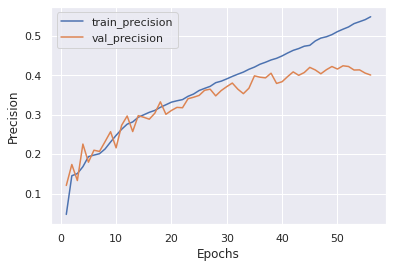

In [46]:
# 視覺化 Precision 結果
sns.set()
plt.plot(range(1, len(train_precision_list)+1), train_precision_list, label="train_precision")
plt.plot(range(1, len(val_precision_list)+1), val_precision_list, label="val_precision")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.show()

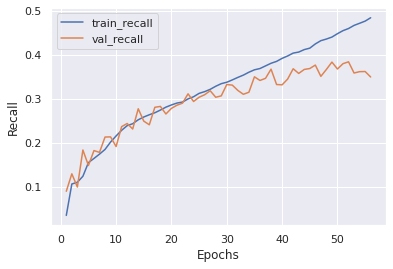

In [47]:
# 視覺化 Recall 結果
sns.set()
plt.plot(range(1, len(train_recall_list)+1), train_recall_list, label="train_recall")
plt.plot(range(1, len(val_recall_list)+1), val_recall_list, label="val_recall")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.show()

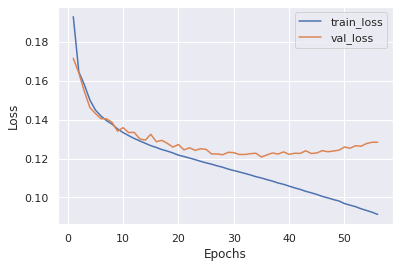

In [48]:
# 視覺化 Loss 結果
plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label="train_loss")
plt.plot(range(1, len(val_loss_list)+1), val_loss_list, label="val_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Model Evaluation

### model 1

In [95]:
NN_SAVE_FILE_NAME = './Model/NN_model_small_batch_size_8_LR_1_4'
model = torch.load(NN_SAVE_FILE_NAME)
def evaluate(model):
    
    model.eval()

    test = Dataset(df=test_df, embedding=test_embedding)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    model = model.to(device)

    accuracy_list = []
    precision_list = []
    recall_list = []
    topk_recall_list = []
    
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():

        for test_embeddings, test_labels in test_dataloader:
            
            test_embeddings = test_embeddings.to(device)
            test_labels = test_labels.to(device)
            
            output = model(test_embeddings).cpu()

      
            pred = (output > 0).cpu()
             # 強迫有個答案
            if((output > 0).sum().item() == 0):
                print('No answer original')
                pred[0][torch.argmax(output).item()] = True
            
            y_true = (test_labels > 0).cpu()
            
            # 計算評估指標
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"Top-5 Recall: {topk_recall}")
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)

            # 印出猜測的結果對應
            y_pred = list(MLB.classes_[pred[0]])
            y_true = list(MLB.classes_[y_true[0]])
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
            # if not MLB.classes_[y_true[0]].any():
            print(f"預測: {y_pred}")
            print(f"正解: {y_true}")
            print("="*30)

    accuracy_res = np.array(accuracy_list).mean()
    precision_res = np.array(precision_list).mean()
    recall_res = np.array(recall_list).mean()
    topk_recall_res = np.array(topk_recall_list).mean()
    
    return accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list
accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list = evaluate(model)
print(NN_SAVE_FILE_NAME)
print(f"LR: {LR}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print("Test Data 結果:")
print(f"Accuracy: {accuracy_res: .3f}")
print(f"Precision: {precision_res: .3f}")
print(f"Recall: {recall_res: .3f}")
print(f"Top-5 Recall: {topk_recall_res: .3f}")

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Health']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Poetry']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Technology']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Startup']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Life']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Mental Health']

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Business']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Startup']
正解: ['Business', 'Startup']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships', 'Self Improvement']
正解: ['Relationships']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Life']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life Lessons']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Data Science', 'Machine Learning']
Accur

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['JavaScript']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Covid 19']
正解: ['Data Science']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Culture']
正解: ['Culture']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Life Lessons', 'Self Improvement']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Programming', 'Software Development']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Politics']
正解: ['Artificial Intelligence']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', '

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Programming']
正解: ['JavaScript']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Health']
正解: ['Design']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Software Development']
正解: ['Programming', 'Software Development']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Culture']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocur

Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry', 'Self']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Design']
正解: ['Covid 19']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Python']
正解: ['Python']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Python']
正解: ['Programming']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry', 'Relationships']
正解: ['Love', 'Relationships']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Software Development']
正解: ['JavaScript', 'Programming', 'Software Development']
Accuracy: 1.0
Precision: 1

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Love']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming', 'Technology']
正解: ['Data Science']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Education']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Programming']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Data Science']
正解: ['Artificial Intelligence', 'Education', 'Machine Learning', 'Software Development']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life', 'Life Lessons', 'Self Improvement']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 1.0
Recall: 0

Accuracy: 0.0
Precision: 1.0
Recall: 0.20000000298023224
Top-5 Recall: 0.6000000238418579
預測: ['Covid 19']
正解: ['Covid 19', 'Culture', 'Health', 'Life', 'Self']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Business', 'Design', 'Marketing']
正解: ['Writing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Data Science']
正解: ['Covid 19', 'Education']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Relationships']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Politics']
正解: ['Technology']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Blockchain']
正解: ['Bitcoin']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Software Development']
正解: ['Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['D

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['JavaScript']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Technology']
正解: ['Education']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Programming', 'Software Development']
正解: ['Programming', 'Software Development']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Poetry']
正解: ['Life Lessons']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.3333333432674408
預測: ['Startup']
正解: ['Artificial Intelligence', 'Data Science', 'Programming']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Poetry', 'Technology']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.333333343

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Self']
正解: ['Health', 'Self', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Relationships']
正解: ['Culture']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Life', 'Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Bitcoin', 'Cryptocurrency']
正解: ['Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life']
正解: ['Culture']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Marketing']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life', 'Life Lessons']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bit

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Covid 19']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Mental Health', 'Self']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Software Development']
正解: ['Blockchain', 'JavaScript', 'Programming']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript', 'Programming']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin',

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.3333333432674408
預測: ['Startup']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 1.0
預測: ['Marketing']
正解: ['Business', 'Marketing', 'Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Education']
正解: ['Programming']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Programming', 'Python']
正解: ['Programming', 'Python']
No answer original

Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Marketing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Cryptocurrency']
正解: ['Blockchain']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Politics']
正解: ['Covid 19']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Python']
正解: ['JavaScript']
Accuracy: 0.0
Precisi

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Life']
正解: ['Mental Health', 'Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Life', 'Life Lessons']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Love']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Software Development']
正解: ['JavaScript']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Technology']
正解: ['Bitcoin', 'Cryptocurrency', 'Culture']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['JavaScript', 'Programming']
正解: ['Python', 'Self']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Data Science', 'Machine Learning']
No answer original
A

Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Marketing', 'Writing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Machine Learning', 'Python']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Design', 'Programming', 'Software Development']
正解: ['JavaScript']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Culture', 'Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1

Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Mental Health', 'Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Life', 'Poetry']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Love', 'Poetry']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Love']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Programming', 'Software Development']
正解: ['Software Development']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript', 'Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Entrepreneurship', 'Life Lessons']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science', 'Machine Learning']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Business']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Love']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Love']
正解: ['Covid 19']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Self Improvement']
正解: ['Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Life Lessons', 'Mental Health', 'Self', 'Self Improvement']
正解: ['Health', 'Lif

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life']
正解: ['Business']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Self Improvement']
正解: ['Life Lessons', 'Startup']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Programming', 'Software Development']
正解: ['Programming', 'Software Development', 'Startup']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Entrepreneurship', 'Startup']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['Programming', 'Software Deve

Accuracy: 0.0
Precision: 1.0
Recall: 0.25
Top-5 Recall: 0.5
預測: ['Politics']
正解: ['Covid 19', 'Health', 'Life Lessons', 'Politics']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Machine Learning']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Business']
正解: ['Business']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Life']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Poetry']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['Programming', 'Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Design']
正解: ['JavaScript', 'Software Development']
Accuracy: 0.0
Precision: 1.0
Recall: 0.33333334326

No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.25
Top-5 Recall: 0.25
預測: ['Life Lessons']
正解: ['Business', 'Entrepreneurship', 'Life Lessons', 'Self Improvement']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Business', 'Entrepreneurship', 'Startup']
正解: ['Business']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Love', 'Relationships']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life', 'Poetry']
正解: ['Life', 'Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Software Development']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Marketing', 'Writing']
No answer original
Accuracy: 1.0
Precision: 1.0
Re

Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design', 'Technology']
正解: ['Design']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Design', 'Programming']
正解: ['Data Science', 'Python']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design', 'Marketing']
正解: ['Marketing']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Programming', 'Python']
正解: ['Python']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Love']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Poetry']
正解: ['Culture', 'Poetry', 'Self']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Love']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Relationships']
正解: ['Love', 'Relationships']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Design']
正解: ['Bus

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Blockchain']
正解: ['Artificial Intelligence', 'Bitcoin']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Data Science', 'Machine Learning', 'Programming']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Politics']
正解: ['Data Science', 'Politics']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Marketing', 'Writing']
正解: ['Business']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Bloc

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Startup']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Life', 'Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life', 'Love']
正解: ['Life Lessons', 'Relationships']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Life Lessons']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.6666666865348816
預測: ['Writing']
正解: ['Life Lessons', 'Relationships', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Technology']
正解: ['Business', 'Marketing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accu

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life']
正解: ['Love']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19', 'Health']
正解: ['Health']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Programming', 'Python']
正解: ['Data Science', 'Python']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Relationships']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Life Lessons', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Covid 19']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Bitcoin']
正解: ['Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Python']
正解: ['Python']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Culture']
正解: ['Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Startup']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Poetry', 'Writing']
正解: ['Life', 'Poetry', 'Writing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Design']
正

Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 0.25
Top-5 Recall: 0.25
預測: ['Data Science', 'Education', 'Programming']
正解: ['JavaScript', 'Programming', 'Software Development', 'Technology']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Programming', 'Software Development']
正解: ['Python', 'Software Development']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Mental Health']
正解: ['Health', 'Mental Health']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life', 'Life Lessons', 'Self Improvement']
正解: ['Life']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Entrepreneurship']
正解: ['Startup']
Accuracy: 0.0
Precision: 1.0
Recall: 0.75
Top-5 Recall: 0.75
預測: ['Data Science', 'Programming', 'Python']
正解: ['Data Science', 'Programming', 'Python', 'Technology']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Data Science', 'Programming']
正解: ['Artificial Intelligence',

./Model/NN_model_small_batch_size_8_LR_1_4
LR: 0.0001
BATCH_SIZE: 8
Test Data 結果:
Accuracy:  0.227
Precision:  0.479
Recall:  0.521
Top-5 Recall:  0.808


### model 2

In [91]:
NN_SAVE_FILE_NAME = './Model/NN_model_small_batch_size_8_LR_1_4_no_pos'
model = torch.load(NN_SAVE_FILE_NAME)
def evaluate(model):
    
    model.eval()

    test = Dataset(df=test_df, embedding=test_embedding)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    model = model.to(device)

    accuracy_list = []
    precision_list = []
    recall_list = []
    topk_recall_list = []
    
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():

        for test_embeddings, test_labels in test_dataloader:
            
            test_embeddings = test_embeddings.to(device)
            test_labels = test_labels.to(device)
            
            output = model(test_embeddings).cpu()

      
            pred = (output > 0).cpu()
             # 強迫有個答案
            if((output > 0).sum().item() == 0):
                print('No answer original')
                pred[0][torch.argmax(output).item()] = True
            
            y_true = (test_labels > 0).cpu()
            
            # 計算評估指標
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"Top-5 Recall: {topk_recall}")
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)

            # 印出猜測的結果對應
            y_pred = list(MLB.classes_[pred[0]])
            y_true = list(MLB.classes_[y_true[0]])
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
            # if not MLB.classes_[y_true[0]].any():
            print(f"預測: {y_pred}")
            print(f"正解: {y_true}")
            print("="*30)

    accuracy_res = np.array(accuracy_list).mean()
    precision_res = np.array(precision_list).mean()
    recall_res = np.array(recall_list).mean()
    topk_recall_res = np.array(topk_recall_list).mean()
    
    return accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list
accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list = evaluate(model)
print(NN_SAVE_FILE_NAME)
print(f"LR: {LR}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print("Test Data 結果:")
print(f"Accuracy: {accuracy_res: .3f}")
print(f"Precision: {precision_res: .3f}")
print(f"Recall: {recall_res: .3f}")
print(f"Top-5 Recall: {topk_recall_res: .3f}")

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Covid 19', 'Health']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Poetry']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Design']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Bitcoin', 'Cryptocurrency', 'Startup']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Life']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5

預測: ['Love', 'Relationships']
正解: ['Love']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry', 'Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Business', 'Marketing', 'Startup']
正解: ['Business', 'Marketing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Relationships']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Business']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Business', 'Startup']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Relationships']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Life']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Business']
正解: ['Politics']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Mental Health']
Accurac

Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Programming', 'Python']
正解: ['Programming', 'Python']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life Lessons', 'Mental Health', 'Self']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Data Science']
正解: ['Artificial Intelligence', 'Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Love', 'Relationships', 'Self']
正解: ['Life', 'Love']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['JavaScript']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Data Scienc

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry', 'Writing']
正解: ['Poetry', 'Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Python']
正解: ['Software Development']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Artificial Intelligence', 'Data Science', 'Machine Learning']
正解: ['Artificial Intelligence', 'Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Self']
正解: ['Life', 'Relationships']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Life']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Covid 19', 'Poetry']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cr

Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Love']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Business']
正解: ['Business']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Love', 'Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Culture']
正解: ['Culture']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life Lessons', 'Self Improvement']
正解: ['Life Lessons', 'Self Improvement']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Mental Health', 'Poetry', 'Self']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.333333343267

Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Business', 'Marketing', 'Startup']
正解: ['Marketing']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Life']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Love', 'Poetry', 'Relationships']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Data Science', 'Programming']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.6666666865348816
預測: ['Life Lessons']

Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Cryptocurrency']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Life Lessons', 'Self', 'Self Improvement']
正解: ['Life', 'Life Lessons', 'Self Improvement']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Startup']
正解: ['Bitcoin', 'Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Culture', 'Writing']
正解: ['Design']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Life']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life']
正解: ['Culture']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Marketing', 'Writing']
正解: ['Marketing']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Love']
正解: ['Love', 'Writing']
Accuracy: 0.0
Precision: 0.5
R

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Mental Health']
正解: ['Self']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['Programming']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health', 'Self Improvement']
正解: ['Life', 'Life Lessons']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Python', 'Software Development']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Life Lessons', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['JavaScript', 'Programming

Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Python']
正解: ['Python']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life Lessons', 'Self', 'Self Improvement']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Machine Learning']
正解: ['Artificial Intelligence']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Bitcoin']
正解: ['Technology']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science', 'Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['JavaScript', 'Programming']
正解: ['Data Science', 'Machine Learning']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Politics']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-

Accuracy: 0.0
Precision: 1.0
Recall: 0.20000000298023224
Top-5 Recall: 0.6000000238418579
預測: ['Business']
正解: ['Business', 'Entrepreneurship', 'Marketing', 'Relationships', 'Startup']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Love']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Education']
正解: ['Marketing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript', 'Programming']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 0.20000000298023224
Top-5 Recall: 0.6000000238418579
預測: ['Mental Health', 'Relationships', 'Self']
正解: ['Health', 'Life', 'Life Lessons', 'Love

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.6666666865348816
預測: ['Self']
正解: ['Life', 'Life Lessons', 'Writing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Love', 'Poetry']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Health']
正解: ['Entrepreneurship', 'Health', 'Self Improvement']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Self Improvement']
正解: ['Marketing']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Data Science']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['Programming']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life', 'Self Improvement']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 R

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Health']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Life Lessons', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Startup']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Design']
正解: ['Data Science']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Love', 'Poetry']
正解: ['Poetry', 'Relationships', 'Self']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Design']
正解: ['Software Development']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Politics']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Life', 'Life Lessons']
Accuracy: 0.0
Precision: 0.0
Re

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Startup']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Data Science']
正解: ['Data Science', 'Machine Learning']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Machine Learning']
正解: ['Machine Learning', 'Python']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Love']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Self']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript', 'Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Self Improvement']
正解: ['Culture', 'Self']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19', 'Politics']
正解: ['Politics']


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Education']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Startup']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Life', 'Love', 'Poetry']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['JavaScript']
正解: ['JavaScript', 'Software Development']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.3333333432674408
Recal

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Life', 'Life Lessons']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Love']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life Lessons', 'Mental Health', 'Self']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health', 'Self Improvement']
正解: ['Health']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.3333333432674408
預測: ['Writing']
正解: ['Entrepreneurship', 'Self Improvement', 'Software Development']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Life Lessons', 'Love']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Life Lessons', 'Love']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Ja

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Life']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Python']
正解: ['Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life Lessons', 'Self Improvement']
正解: ['Self']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Education']
正解: ['Marketing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript', 'Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Culture', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Life']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technol

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Programming']
正解: ['Python']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Self Improvement']
正解: ['Self', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Data Science', 'Python']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Technology']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Politics']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Writing']
正解: ['Education', 'Self Improvement']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Relationships']
正解: ['Relationships']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Re

Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 0.6666666865348816
Top-5 Recall: 0.6666666865348816
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Artificial Intelligence', 'Bitcoin', 'Blockchain']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry', 'Writing']
正解: ['Life', 'Writing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Mental Health', 'Technology']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Data Science']
正解: ['Machine Learning', 'Python']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 0.6666666865348816
Top-5 Recall: 0.6666666865348816
預測: ['Business', 'Entrepreneurship', 'Startup']
正解: ['Entrepreneurship', 'Life', 'Startup']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Self', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Block

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Relationships']
正解: ['Life']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Data Science', 'Machine Learning']
正解: ['JavaScript']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Self', 'Self Improvement']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Artificial Intelligence', 'Technology']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Life', 'Poetry']
正解: ['Poetry', 'Politics']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Li

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Python']
正解: ['Software Development']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Software Development']
正解: ['Entrepreneurship', 'Startup']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Artificial Intelligence', 'Technology']
正解: ['Technology']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 1.0
預測: ['Mental Health']
正解: ['Life', 'Mental Health', 'Self']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Bitcoin']
正解: ['Business']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Cryptocurrency']
正解: ['Bitcoin']
Accurac

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Love', 'Poetry']
正解: ['Self']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Love', 'Relationships']
正解: ['Culture', 'Life']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Entrepreneurship', 'Startup']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Programming', 'Software Development', 'Technology']
正解: ['JavaScript', 'Programming']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Life']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Startu

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Covid 19']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Relationships']
正解: ['Relationships']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Self Improvement']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Covid 19']
正解: ['Culture']
Accuracy: 0.0
Precision: 1.0
Recall: 0.25
Top-5 Recall: 0.5
預測: ['Self Improvement']
正解: ['Life Lessons', 'Mental Health', 'Self Improvement', 'Technology']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life Lessons', 'Love', 'Self Improvement']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design', 'Writing']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Programming', 'Self Improvement']
正解: ['Life Lessons', 'Self Improvement']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Self', 'Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Mental Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry', 'Writing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Self Improvement']
正解: ['Health']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Love', 'Relationships']
正解: ['Lif

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Programming', 'Software Development']
正解: ['Software Development']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Life Lessons', 'Self Improvement']
正解: ['Mental Health', 'Self']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Data Science', 'Python']
正解: ['Programming', 'Python']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Programming', 'Software Development', 'Startup']
正解: ['Life']
Accuracy: 0.0
Precision: 0.5
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Artificial Intelligence', 'Blockchain',

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Health', 'Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life Lessons', 'Self Improvement']
正解: ['Life Lessons']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Covid 19']
正解: ['Co

No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life']
正解: ['Self']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Business']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry', 'Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Entrepreneurship']
正解: ['Entrepreneurship']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Technology']
正解: ['Education']
Accuracy: 0.0
Precision: 0.0
Recall: 0.

### model 3

In [103]:
NN_SAVE_FILE_NAME = './Model/NN_model_small_3_batch_size_8_LR_1_4'
model = torch.load(NN_SAVE_FILE_NAME)
def evaluate(model):
    
    model.eval()

    test = Dataset(df=test_df, embedding=test_embedding)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)

    model = model.to(device)

    accuracy_list = []
    precision_list = []
    recall_list = []
    topk_recall_list = []
    
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():

        for test_embeddings, test_labels in test_dataloader:
            
            test_embeddings = test_embeddings.to(device)
            test_labels = test_labels.to(device)
            
            output = model(test_embeddings).cpu()

      
            pred = (output > 0).cpu()
             # 強迫有個答案
            if((output > 0).sum().item() == 0):
                print('No answer original')
                pred[0][torch.argmax(output).item()] = True
            
            y_true = (test_labels > 0).cpu()
            
            # 計算評估指標
            accuracy, precision, recall, topk_recall = score(y_true, pred, output, k=5)
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}")
            print(f"Top-5 Recall: {topk_recall}")
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            topk_recall_list.append(topk_recall)

            # 印出猜測的結果對應
            y_pred = list(MLB.classes_[pred[0]])
            y_true = list(MLB.classes_[y_true[0]])
            y_pred_list.append(y_pred)
            y_true_list.append(y_true)
            # if not MLB.classes_[y_true[0]].any():
            print(f"預測: {y_pred}")
            print(f"正解: {y_true}")
            print("="*30)

    accuracy_res = np.array(accuracy_list).mean()
    precision_res = np.array(precision_list).mean()
    recall_res = np.array(recall_list).mean()
    topk_recall_res = np.array(topk_recall_list).mean()
    
    return accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list
accuracy_res, precision_res, recall_res, topk_recall_res, y_pred_list, y_true_list = evaluate(model)
print(NN_SAVE_FILE_NAME)
print(f"LR: {LR}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print("Test Data 結果:")
print(f"Accuracy: {accuracy_res: .3f}")
print(f"Precision: {precision_res: .3f}")
print(f"Recall: {recall_res: .3f}")
print(f"Top-5 Recall: {topk_recall_res: .3f}")

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Health']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Poetry']
正解: ['Covid 19']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Data Science']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Entrepreneurship', 'Startup']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Technology']
正解: ['Life']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 R

Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Life', 'Poetry', 'Relationships']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.25
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Data Science', 'JavaScript', 'Programming', 'Python']
正解: ['Education', 'Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Software Development']
正解: ['Programming']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Health']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解:

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Design']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Python']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Life Lessons']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Health']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Marketing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Health']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.0
Reca

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Startup']
正解: ['Data Science']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['JavaScript']
正解: ['Programming']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Health']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Covid 19']
正解: ['Business']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Culture']
正解: ['Covid 19']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Mental Health']
正解: ['Mental Health']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design', 'Technology']
正解: ['Technology']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['JavaScript', 'Programming']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life']
正解: ['Culture', 'Writing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Life']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Software Development']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Machine Learning', 'Programming', 'Python']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Culture']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Culture', 'Technology']
Accuracy: 1.0
Precision: 1.0
Recall: 1

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Politics']
正解: ['Life']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Programming', 'Python']
正解: ['Data Science']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['JavaScript']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Life', 'Life Lessons']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Love', 'Relationships']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Culture']
正解: ['Education']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Startup'

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['JavaScript']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Programming', 'Python']
正解: ['Programming', 'Python']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Love']
正解: ['Health']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Love']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Data Science']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Education']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 0.0
Precision: 0.3333333432

No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Health']
正解: ['Culture', 'Health']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design', 'Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Design']
正解: ['Culture', 'Technology']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Entrepreneurship', 'Startup']
正解: ['Business']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Mental Health']
正解: ['Writin

Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health', 'Mental Health']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Software Development']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Poetry', 'Writing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Marketing', 'Startup']
正解: ['Business']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: [

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.6666666865348816
預測: ['Data Science']
正解: ['Blockchain', 'Cryptocurrency', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Self']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Programming']
正解: ['Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Life', 'Life Lessons']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.3333333432674408
預測: ['Programming']
正解: ['JavaScript', 'Programming', 'Technology']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Entrepreneurship', 'Startup']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Programming']
正解: ['Data Science', 'Machine Learning']
Accu

No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Life Lessons']
正解: ['Life Lessons', 'Self Improvement']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Culture']
正解: ['Bitcoin', 'Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Mental Health']
正解: ['Writing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Startup']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Startup']
正解: ['Entrepreneurship']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Data Science', 'Machine Learning']
正解: ['Design']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bloc

Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Love', 'Relationships']
正解: ['Poetry', 'Writing']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Relationships']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Health', 'Mental Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0

Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['Programming']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Life']
正解: ['Life', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Blockchain']
正解: ['Startup']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Business']
正解: ['Business', 'Entrepreneurship', 'Startup']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Love']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design', 'Startup']
正解: ['Design', 'Startup']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Business', 'Startup']
正解: ['Business']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0

Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Software Development']
正解: ['Programming']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Relationships']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Covid 19']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.20000000298023224
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life', 'Life Lessons', 'Mental Health', 'Self', 'Self Improvement']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Mental Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Design']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['

Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Love', 'Relationships']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Cryptocurrency']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Culture']
正解: ['Culture']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 R

Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Python']
正解: ['Python']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Python']
正解: ['Data Science']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Relationships']
正解: ['Love']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Bitcoin']
正解: ['Bitcoin', 'Business']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Self Improvement']
正解: ['Education']
Accuracy: 0.0
Precision: 0.75
Recall: 0.6000000238418579
Top-5 Recall: 0.6000000238418579
預測: ['Data Science', 'Machine Learning', 'Programming', 'Python']
正解: ['Data Science', 'Programming', 'Python', 'Software Development', 'Technology']
Accuracy: 1.0
Precision

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['JavaScript']
正解: ['Data Science']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Poetry']
正解: ['Relationships']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Education']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Artificial Intelligence', 'Data Science', 'Machine Learning']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Programming']
正解: ['Design']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Mental Health']
正解: ['Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1

Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Blockchain']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Poetry']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Python']
正解: ['Python', 'Software Development']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Marketing']
正解: ['Blockchain', 'Politics']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Mental Health', 'Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Life', 'Poetry']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bit

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Writing']
正解: ['Culture', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Love', 'Relationships']
正解: ['Life']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Life']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Entrepreneurship', 'Startup']
正解: ['Startup']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Entrepreneurship', 'Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測:

No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Covid 19']
正解: ['Artificial Intelligence', 'Covid 19']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Mental Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Startup']
正解: ['Education']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Writing']
正解: ['Entrepreneurship', 'Startup', 'Writing']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Business', 'Writing']
No answer or

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Love']
正解: ['Self']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Bitcoin']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Love']
正解: ['Love']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Life', 'Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Design']
正解: ['Software Development']
Accuracy: 0.0

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Relationships']
正解: ['Covid 19', 'Life']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Health', 'Mental Health']
正解: ['Culture', 'Health']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Relationships']
正解: ['Poetry']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Politics']
正解: ['Education']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Love', 'Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Artificial Intelligence', 'Data Science', 'Machine Learning']
Accuracy: 0.0
Precisi

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Marketing', 'Writing']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 1.0
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Poetry']
正解: ['Covid 19', 'Life', 'Poetry']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['JavaScript', 'Programming', 'Software Development']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Programming', 'Python']
正解: ['Programming']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Health']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Rec

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Marketing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Life Lessons']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Mental Health', 'Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Startup']
正解: ['Startup']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Artificial Intelligence', 'Life', 'Technology']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Programming']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Li

Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Programming']
正解: ['JavaScript', 'Programming']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Life']
正解: ['Life']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Startup']
正解: ['Marketing', 'Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Self Improvement']
正解: ['Education']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Marketing']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Blockchain']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Data Science', 'Machine Learning']
正解: ['Blockchain', 'Cryptocurrency']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Design']
正解:

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Programming', 'Software Development', 'Startup']
正解: ['Blockchain', 'Software Development']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Business']
正解: ['Startup']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Health']
正解: ['Business', 'Startup']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Health']
正解: ['Health']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 0.3333333432674408
Top-5 Recall: 0.6666666865348816
預測: ['Data Science', 'Programming', 'Python']
正解: ['Artificial Intelligence', 'Data Science', 'Machine Learning']
No answer original
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Love']
正解: ['Love', 'Rela

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Writing']
正解: ['Writing']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Poetry']
正解: ['Covid 19']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Technology']
正解: ['Entrepreneurship']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Writing']
正解: ['Self', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Self Improvement']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin', 'Blockchain']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Covid 19']
正解: ['Covid 19']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precisi

Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming', 'Software Development']
正解: ['Programming', 'Software Development']
No answer original
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Mental Health']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Programming', 'Software Development']
正解: ['Data Science']
Accuracy: 0.0
Precision: 0.800000011920929
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Artificial Intelligence', 'Data Science', 'Machine Learning', 'Programming', 'Python']
正解: ['Data Science', 'Machine Learning', 'Programming', 'Python']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Writing']
正解: ['Life', 'Life Lessons']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Life Lessons']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accura

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Startup']
Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Poetry', 'Writing']
正解: ['Life', 'Poetry', 'Writing']
Accuracy: 0.0
Precision: 0.25
Recall: 0.3333333432674408
Top-5 Recall: 0.3333333432674408
預測: ['Data Science', 'Machine Learning', 'Programming', 'Python']
正解: ['Programming', 'Software Development', 'Technology']
No answer original
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.5
預測: ['Life']
正解: ['Relationships', 'Self Improvement']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['JavaScript', 'Programming']
正解: ['Covid 19']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Culture', 'Politics']
正解: ['Culture', 'Politics']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Love', 'Relationships']
正解: ['Mental Health']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.6666666865348816
預測: ['Startup']

Accuracy: 0.0
Precision: 1.0
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Love', 'Poetry']
正解: ['Love', 'Poetry', 'Relationships']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Bitcoin']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 0.5
預測: ['Poetry']
正解: ['Life Lessons', 'Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['Programming']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Artificial Intelligence', 'Data Science', 'Machine Learning']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.6666666865348816
Recall: 0.6666666865348816
Top-5 Recall: 1.0
預測: ['Blockchain', 'Cryptocurrency', 'Startup']
正解: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
Accuracy: 0.0
Precision: 0.5
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning']
正解: ['Machine Learning']
Accuracy: 0.0
Precision: 0.0
R

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Technology']
正解: ['Technology']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Business']
正解: ['Education']
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
Top-5 Recall: 0.0
預測: ['Life', 'Self Improvement']
正解: ['Covid 19']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Data Science', 'Machine Learning', 'Python']
正解: ['Machine Learning']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Poetry']
正解: ['Poetry']
Accuracy: 0.0
Precision: 0.5
Recall: 0.5
Top-5 Recall: 1.0
預測: ['JavaScript', 'Programming']
正解: ['Programming', 'Software Development']
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Politics']
正解: ['Politics']
Accuracy: 0.0
Precision: 0.3333333432674408
Recall: 1.0
Top-5 Recall: 1.0
預測: ['Bitcoin', 'Blockchain', 'Cryptocurrency']
正解: ['Blockchain']
Accuracy: 0.0
Precision: 1.0
Recall: 0.5
Top-5 Recall: 1.0
預測: ['Education']
正解: ['Covid 1

### 各類別表現

In [48]:
print(f"目標變數數量: {len(list(MLB.classes_))} 類")
detail_res_dict = {c: {x: 0 for x in ["TP", "TN", "FP", "FN"]} for c in list(MLB.classes_)}

目標變數數量: 30 類


In [49]:
# 計算各類別的 TP, FP, TN, FN
for pred_, true_ in zip(y_pred_list, y_true_list):
    for guess in pred_:
        if guess in true_:
            detail_res_dict[guess]["TP"] += 1
        else:
            detail_res_dict[guess]["FP"] += 1
    for label in true_:
        if label not in pred_:
            detail_res_dict[label]["FN"] += 1
    others = set(MLB.classes_) - (set(pred_) | set(true_))
    for each in others:
        detail_res_dict[each]["TN"] += 1

In [50]:
# 建立 Data Frame
detail_res_df = pd.DataFrame(detail_res_dict).T

In [51]:
detail_res_df["Recall"] = round(detail_res_df["TP"] / (detail_res_df["TP"] + detail_res_df["FN"]), 2)
detail_res_df["Precision"] = round(detail_res_df["TP"] / (detail_res_df["TP"] + detail_res_df["FP"]), 2)

In [52]:
detail_res_df

,TP,TN,FP,FN,Recall,Precision
Artificial Intelligence,37,5719,59,112,0.25,0.39
Bitcoin,318,5196,329,84,0.79,0.49
Blockchain,435,5049,357,86,0.83,0.55
Business,24,5722,33,148,0.14,0.42
Covid 19,55,5698,22,152,0.27,0.71
Cryptocurrency,386,5163,305,73,0.84,0.56
Culture,23,5748,43,113,0.17,0.35
Data Science,132,5484,135,176,0.43,0.49
Design,82,5660,88,97,0.46,0.48
Education,45,5728,23,131,0.26,0.66
